# Import Data 


In [0]:
import requests
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import pprint
from pyspark.sql.functions import from_unixtime, col, mean, stddev, abs as pyspark_abs
import pandas as pd
from pyspark.sql.functions import col, count, split, size, length, when, isnan, regexp_extract, expr
ps.set_option('plotting.backend', 'matplotlib')
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType
import re

# Initialize Spark session
spark = SparkSession.builder.appName("ReadCSVFile").getOrCreate()

# Define the presigned URL
local_file_path = 'dbfs:/FileStore/files/FinalClean_100K.csv'

# Load the local CSV file into a pandas-on-Spark DataFrame
df = ps.read_csv(local_file_path, sep=";")

# Show the first few rows of the DataFrame
df.head()


category                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         body                                                                                                 amenities  bathrooms  bedrooms currency fee  has_photo pets_allowed   price price_type  square_feet       cityname state  latitude  longitude        source                time  week_of_month  has_Tennis  has_Parking  has_Alarm  has_Golf  has_TV  has_Clubhouse  has_Playground  has_Refrigerator  has_Cable_or_Satellite  has_Unknown  has_Gated  has_Pool  has_Wood_Floors  has_Internet_Access  has_View  has_Elevator  has_Hot_Tub  has_Gym  has_Storage  has_Doorman  has_Dishwasher  has_Washer_Dryer  has_Patio/Deck  has_Garbage_Disposal  has_Luxury  has_AC  has_Fireplace  has_photo_no  has_photo_yes  pets_allowed_None  pets_allowed_Yes
0            housing/rent         Excellent home with 2 bdrooms, loft, and 1 BA. $800/mo                                                                                                                                                                                                                                                                                                                                                       Every room has a ceiling fan in it, along with fresh new paint. Also, new carpet in the famiy and living rooms. New HVAC, Furnace and ADT security system installed as well. Pet deposit of $450. The front yard is fenced in, and the home currently has siding, and new upgraded lighting in the backyard. Excellent access to the bus-line right on Prospect, and right off of 71-. Local banks, and restaurants also located very nearby the home. Ok for pets, Overhead fans, Fireplace, secure System, Hook-ups, Stove, Refrigerator, Smoking Allowed, Accessible Parking Close to Home, Doorways 32" or Wider, Accessible Path to & in Home, 1st Floor Bathroom, Audio/Visual Smoke/Fire Alarm.                                                                              Alarm,Fireplace,Refrigerator        1.0         3      USD  No        Yes    Cats,Dogs   800.0    Monthly       2500.0    Kansas City    MO   39.0342   -94.5429  RentDigs.com 2019-02-22 07:39:28              4           0            0          1         0       0              0               0                 1                       0            0          0         0                0                    0         0             0            0        0            0            0               0                 0               0                     0           0       0              1             0              1                  0                 1
1  housing/rent/apartment                $1,000 / Two BR - Great Deal. MUST SEE. Cat OK!                                                                                                                                                                                                                                                       

In [0]:
display(df.columns)

Index(['category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms',
       'currency', 'fee', 'has_photo', 'pets_allowed', 'price', 'price_type',
       'square_feet', 'cityname', 'state', 'latitude', 'longitude', 'source',
       'time', 'week_of_month', 'has_Tennis', 'has_Parking', 'has_Alarm',
       'has_Golf', 'has_TV', 'has_Clubhouse', 'has_Playground',
       'has_Refrigerator', 'has_Cable_or_Satellite', 'has_Unknown',
       'has_Gated', 'has_Pool', 'has_Wood_Floors', 'has_Internet_Access',
       'has_View', 'has_Elevator', 'has_Hot_Tub', 'has_Gym', 'has_Storage',
       'has_Doorman', 'has_Dishwasher', 'has_Washer_Dryer', 'has_Patio/Deck',
       'has_Garbage_Disposal', 'has_Luxury', 'has_AC', 'has_Fireplace',
       'has_photo_no', 'has_photo_yes', 'pets_allowed_None',
       'pets_allowed_Yes'],
      dtype='object')

In [0]:
included_numeric_types= ['float64', 'int64', 'float32','int32','int64','int8']
numeric_df = df.select_dtypes(include=included_numeric_types)
numeric_df.columns

Index(['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude',
       'longitude', 'week_of_month', 'has_Tennis', 'has_Parking', 'has_Alarm',
       'has_Golf', 'has_TV', 'has_Clubhouse', 'has_Playground',
       'has_Refrigerator', 'has_Cable_or_Satellite', 'has_Unknown',
       'has_Gated', 'has_Pool', 'has_Wood_Floors', 'has_Internet_Access',
       'has_View', 'has_Elevator', 'has_Hot_Tub', 'has_Gym', 'has_Storage',
       'has_Doorman', 'has_Dishwasher', 'has_Washer_Dryer', 'has_Patio/Deck',
       'has_Garbage_Disposal', 'has_Luxury', 'has_AC', 'has_Fireplace',
       'has_photo_no', 'has_photo_yes', 'pets_allowed_None',
       'pets_allowed_Yes'],
      dtype='object')

In [0]:
numeric_df.head()

bathrooms  bedrooms   price  square_feet  latitude  longitude  week_of_month  has_Tennis  has_Parking  has_Alarm  has_Golf  has_TV  has_Clubhouse  has_Playground  has_Refrigerator  has_Cable_or_Satellite  has_Unknown  has_Gated  has_Pool  has_Wood_Floors  has_Internet_Access  has_View  has_Elevator  has_Hot_Tub  has_Gym  has_Storage  has_Doorman  has_Dishwasher  has_Washer_Dryer  has_Patio/Deck  has_Garbage_Disposal  has_Luxury  has_AC  has_Fireplace  has_photo_no  has_photo_yes  pets_allowed_None  pets_allowed_Yes
6056        2.0         2  1007.0        955.0   35.7551   -78.7199              3           1            0          0         0       0              0               0                 0                       0            0          0         1                0                    0         0             0            0        1            0            0               0                 0               0                     0           0       0              1             0              1                  0                 1
6057        1.0         1  1009.0        780.0   36.1106   -79.7406              3           0            0          0         0       0              0               0                 0                       0            0          0         0                0                    0         0             0            0        0            0            0               0                 1               0                     0           0       0              0             0              1                  0                 1
6058        1.0         2  1010.0       1075.0   36.8379   -76.0939              3           0            0          0         0       0              1               0                 0                       0            0          0         1                0                    1         0             0            0        1            0            0               0                 1               1                     0           0       0              0             0              0                  0                 1
6059        1.0         1  1010.0        659.0   39.1627   -76.6354              3           0            0          0         0       0              0               0                 1                       1            0          0         1                0                    1         0             0            0        0            0            0               1                 1               1                     0           0       1              0             0              1                  0                 1
6060        2.0         2  1011.0       1000.0   33.9743   -84.2384              2           1            0          0         0       0              1               1                 0                       0            0          0         1                0                    1         0             0            0        0            0            0               0                 0               1                     0           0       0              1             0              1                  0                 1

In [0]:
print(numeric_df.columns)

Index(['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude',
       'longitude', 'week_of_month', 'has_Tennis', 'has_Parking', 'has_Alarm',
       'has_Golf', 'has_TV', 'has_Clubhouse', 'has_Playground',
       'has_Refrigerator', 'has_Cable_or_Satellite', 'has_Unknown',
       'has_Gated', 'has_Pool', 'has_Wood_Floors', 'has_Internet_Access',
       'has_View', 'has_Elevator', 'has_Hot_Tub', 'has_Gym', 'has_Storage',
       'has_Doorman', 'has_Dishwasher', 'has_Washer_Dryer', 'has_Patio/Deck',
       'has_Garbage_Disposal', 'has_Luxury', 'has_AC', 'has_Fireplace',
       'has_photo_no', 'has_photo_yes', 'pets_allowed_None',
       'pets_allowed_Yes'],
      dtype='object')


In [0]:
#remove spatial outliers. 
numeric_df = numeric_df[numeric_df['longitude'] >= -130]
numeric_df = numeric_df.drop(columns='pets_allowed_None')

In [0]:
numeric_df.head()

bathrooms  bedrooms   price  square_feet  latitude  longitude  week_of_month  has_Tennis  has_Parking  has_Alarm  has_Golf  has_TV  has_Clubhouse  has_Playground  has_Refrigerator  has_Cable_or_Satellite  has_Unknown  has_Gated  has_Pool  has_Wood_Floors  has_Internet_Access  has_View  has_Elevator  has_Hot_Tub  has_Gym  has_Storage  has_Doorman  has_Dishwasher  has_Washer_Dryer  has_Patio/Deck  has_Garbage_Disposal  has_Luxury  has_AC  has_Fireplace  has_photo_no  has_photo_yes  pets_allowed_Yes
0        1.0         3   800.0       2500.0   39.0342   -94.5429              4           0            0          1         0       0              0               0                 1                       0            0          0         0                0                    0         0             0            0        0            0            0               0                 0               0                     0           0       0              1             0              1                 1
1        2.0         2  1000.0        875.0   37.5423   -77.4347              4           0            0          0         0       1              0               0                 1                       1            0          0         0                1                    1         0             0            0        0            0            0               1                 0               1                     1           0       1              0             0              1                 1
2        1.0         1  1017.0        780.0   33.9222   -84.0725              3           1            0          0         0       0              0               0                 1                       0            0          1         1                0                    0         0             0            0        1            0            0               1                 1               1                     0           0       1              1             0              0                 1
3        2.0         2  1023.0       1115.0   36.1599   -78.8975              3           0            1          0         0       0              0               0                 0                       0            0          0         1                0                    0         0             0            0        0            0            0               0                 1               0                     0           0       0              0             0              1                 1
4        1.5         2  1025.0       1300.0   28.0395   -82.3952              4           0            0          0         0       0              0               0                 0                       0            0          0         1                0                    0         0             0            0        0            0            0               0                 0               0                     0           0       0              0             0              1                 1

In [0]:
import pyspark.pandas as ps

# Assuming numeric_df is your Spark on Pandas DataFrame
# Select only the columns you want
columns_to_include = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude']
selected_df = numeric_df[columns_to_include]

# Generate the description
description = selected_df.describe()

# Function to format to 2 decimal places
def format_to_2_decimals(x):
    try:
        return f"{float(x):.2f}"
    except (ValueError, TypeError):
        return x

# Apply the formatting function to all cells except the 'count' row
formatted_description = description.apply(lambda x: x.map(format_to_2_decimals) if x.name != 'count' else x)

# Display the result
display(formatted_description)

bathrooms bedrooms price square_feet latitude longitude 99517.00 99517.00 99517.00 99517.00 99517.00 99517.00 1.44 1.73 1525.54 956.05 36.93 -91.49 0.55 0.75 902.06 387.22 4.56 15.74 0.00 0.00 100.00 101.00 24.56 -124.23 1.00 1.00 1014.00 730.00 33.75 -104.79 1.00 2.00 1350.00 900.00 37.21 -84.54 2.00 2.00 1795.00 1115.00 39.96 -77.57 9.00 9.00 52500.00 40000.00 48.85 -68.78

In [0]:
numeric_df.describe()

bathrooms      bedrooms         price   square_feet      latitude     longitude  week_of_month    has_Tennis   has_Parking     has_Alarm      has_Golf        has_TV  has_Clubhouse  has_Playground  has_Refrigerator  has_Cable_or_Satellite   has_Unknown     has_Gated      has_Pool  has_Wood_Floors  has_Internet_Access      has_View  has_Elevator   has_Hot_Tub       has_Gym   has_Storage   has_Doorman  has_Dishwasher  has_Washer_Dryer  has_Patio/Deck  has_Garbage_Disposal   has_Luxury        has_AC  has_Fireplace  has_photo_no  has_photo_yes  pets_allowed_Yes
count  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000   99517.000000  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000   99517.000000    99517.000000      99517.000000            99517.000000  99517.000000  99517.000000  99517.000000     99517.000000         99517.000000  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000    99517.000000      99517.000000    99517.000000          99517.000000  99517.00000  99517.000000   99517.000000  99517.000000   99517.000000      99517.000000
mean       1.444628      1.725745   1525.544319    956.051479     36.934093    -91.487287       3.161992      0.085664      0.441040      0.003658      0.000271      0.045279       0.192389        0.113930          0.149874                0.126029      0.159953      0.087171      0.438227         0.089251             0.111549      0.021042      0.043601      0.040124      0.375896      0.217923      0.002191        0.166776          0.262096        0.266879              0.038938      0.00208      0.159159       0.150316      0.092748       0.562818          0.949516
std        0.547771      0.750469    902.055852    387.219284      4.560699     15.737561       0.834220      0.279868      0.496514      0.060368      0.016469      0.207916       0.394179        0.317728          0.356950                0.331883      0.366564      0.282087      0.496172         0.285107             0.314812      0.143524      0.204206      0.196251      0.484356      0.412837      0.046753        0.372777          0.439777        0.442331              0.193448      0.04556      0.365826       0.357383      0.290080       0.496041          0.218942
min        0.000000      0.000000    100.000000    101.000000     24.564500   -124.226500       1.000000      0.000000      0.000000      0.000000      0.000000      0.000000       0.000000        0.000000          0.000000                0.000000      0.000000      0.000000      0.000000         0.000000             0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000        0.000000          0.000000        0.000000              0.000000      0.00000      0.000000       0.000000      0.000000       0.000000          0.000000
25%        1.000000      1.000000   1014.000000    730.000000     33.746500   -104.791900       3.000000      0.000000      0.000000      0.000000      0.000000      0.000000       0.000000        0.000000          0.000000                0.000000      0.000000      0.000000      0.000000         0.000000             0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000        0.000000          0.000000        0.000000              0.000000      0.00000      0.000000       0.000000      0.000000       0.000000          1.000000
50%        1.000000      2.000000   1350.000000    900.000000     37.213900    -84.538200       3.000000      0.000000      0.000000      0.000000      0.000000      0.000000       0.000000        0.000000          0.000000                0.000000      0.000000      0.000000      0.000000         0.000000             0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000        0.000000          0.000000        0.000000              0.000000      0.00000      0.000000       0.000000      0.000000       1.000000          1.000000

### Correlation Matrix

Our data may have a lot of highly correlated columns so we need to perform a bit of feature reduction to decrease multicollinearity. We start with a correlation matrix heatmap to view columns with correlations higher than .6

We removed highly correlated and constant columns in our data preprocessing but we may need to continue removing columns. Currently, bedroom, bathrooms, and square footage is highly correlated which makes sense. We may not be able to untangle this easily, we will perform VIF analysis to see if there are any very highly correlated columns which we can edit there. 

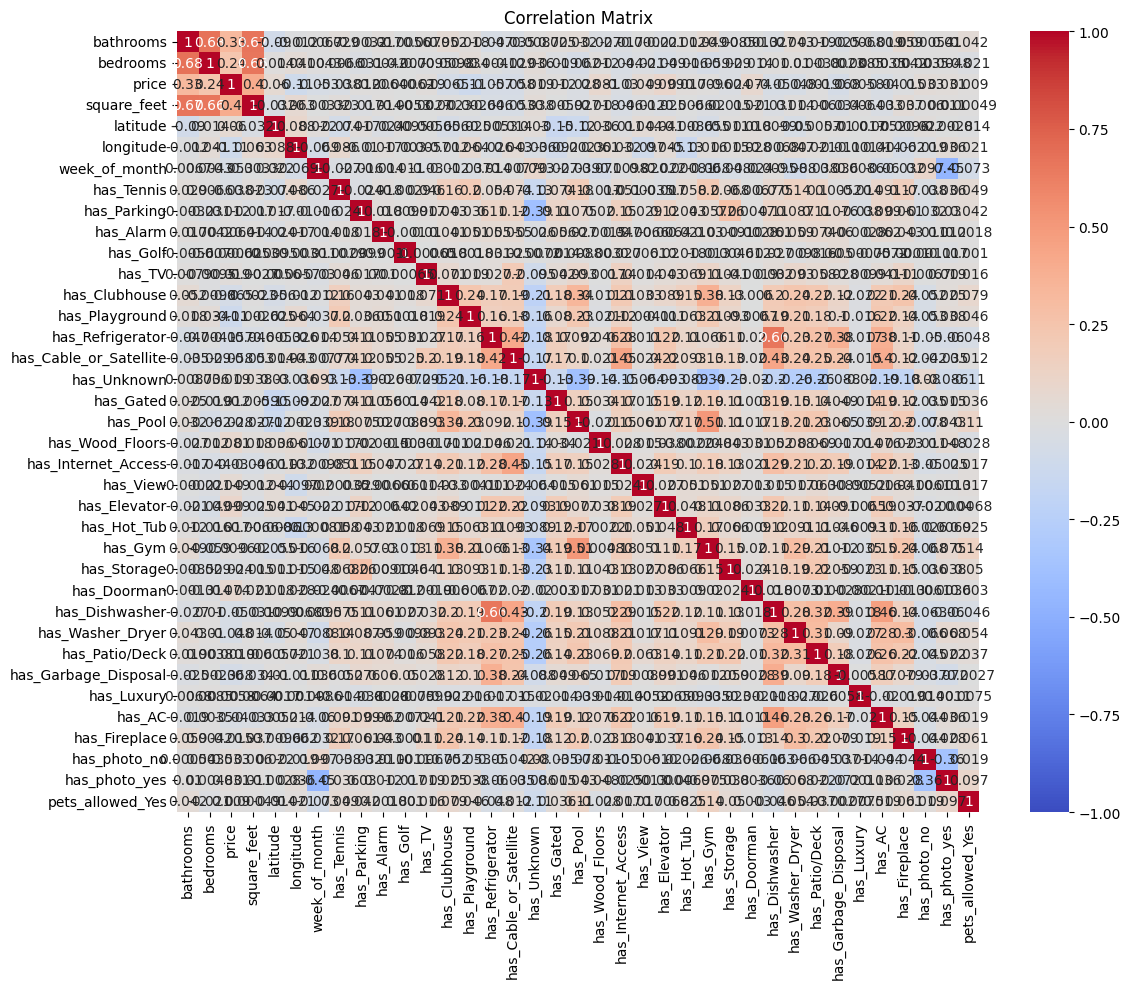

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numeric_column_names = numeric_df.columns.tolist()
# Convert pandas-on-Spark DataFrame to PySpark DataFrame
df_spark = numeric_df.to_spark()

# Convert to vector column
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_spark.columns, outputCol=vector_col)
df_vector = assembler.transform(df_spark).select(vector_col)

# Calculate correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# Convert to numpy array
corr_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].toArray()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            xticklabels=numeric_column_names, yticklabels=numeric_column_names)
plt.title('Correlation Matrix')
plt.tight_layout()


We must remove the has_unknown column to decrease ambiguity of the features. Same with allows_pets_unknown. These were added as the NaN values and we filled them with 'unknown'



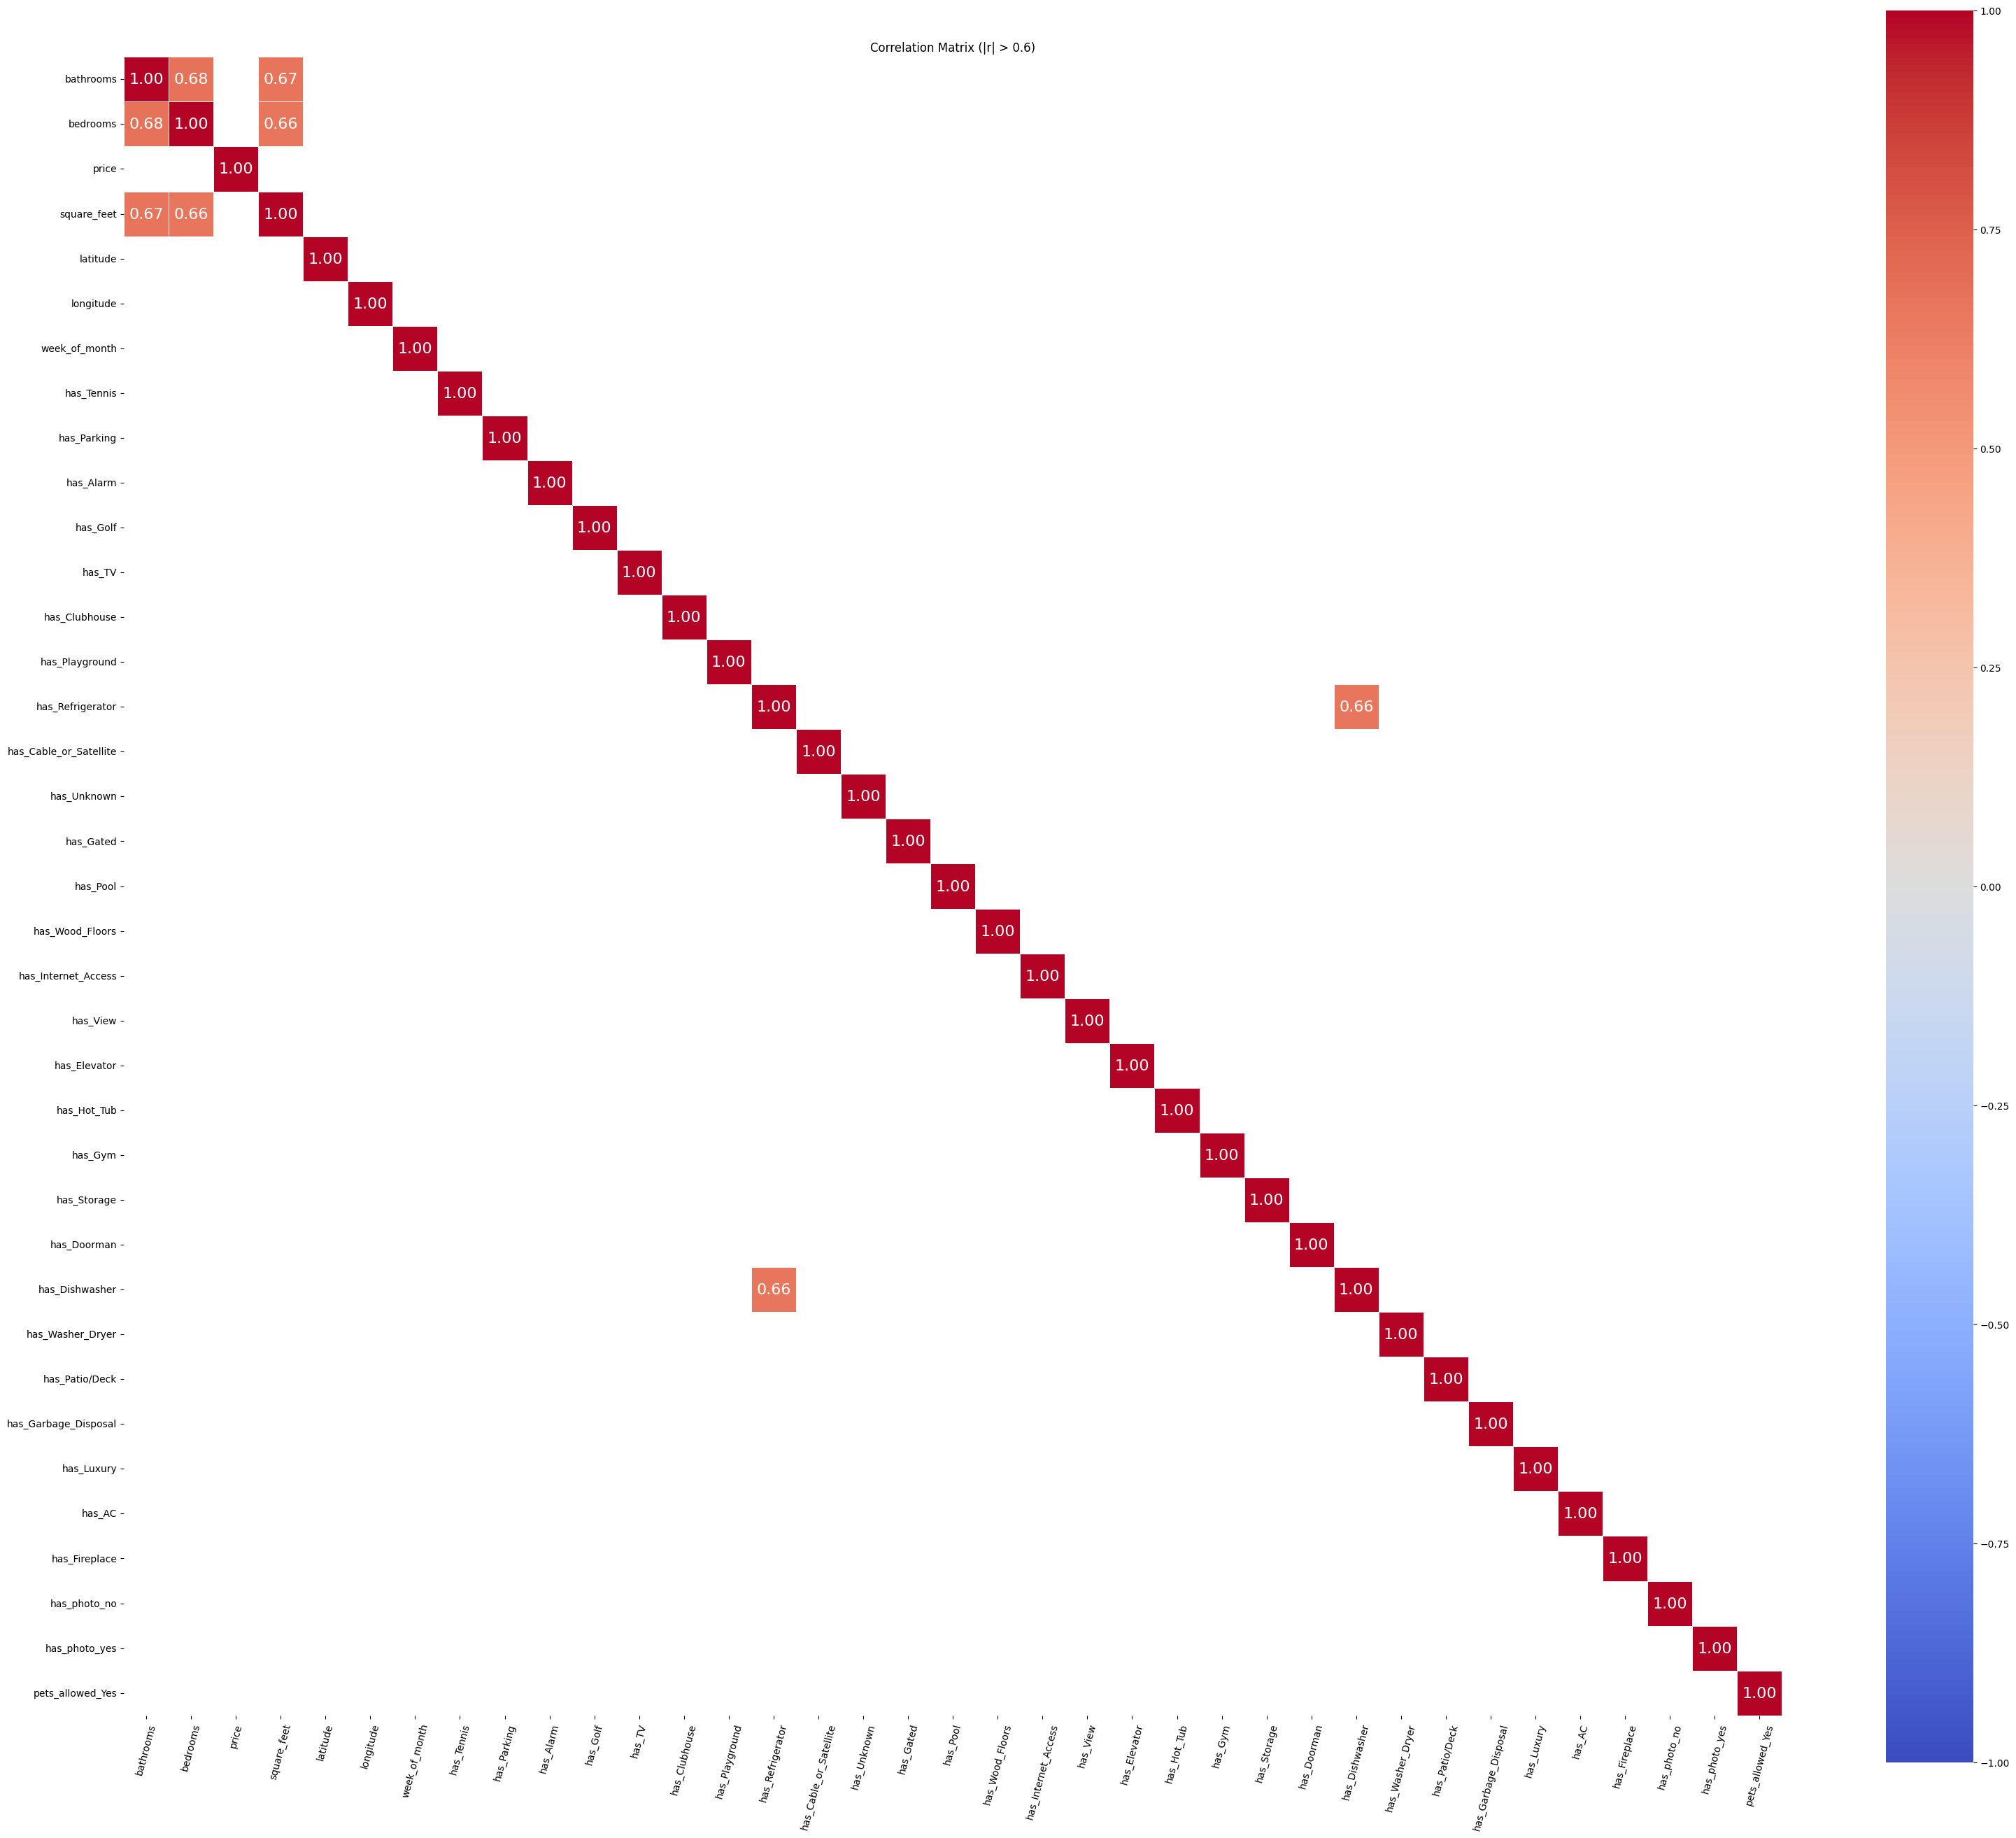

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def compute_correlation_matrix(df, method='pearson', threshold=0.6):

    numeric_columns = df.columns.tolist()

    # Convert pandas-on-Spark DataFrame to PySpark DataFrame
    df_spark = df[numeric_columns].to_spark()

    # Create a vector column
    vector_col = "features"
    assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
    df_vector = assembler.transform(df_spark)

    # Cache the dataset
    df_vector.cache()

    # Calculate correlation matrix
    correlation = Correlation.corr(df_vector, vector_col, method)

    # Extract the correlation matrix
    correlation_matrix = correlation.collect()[0][0].toArray()

    # Unpersist the cached data
    df_vector.unpersist()

    return correlation_matrix, numeric_columns

def plot_correlation_heatmap(correlation_matrix, column_names, threshold=0.6, title='Correlation Matrix'):
    # Create a mask for correlations below the threshold (in absolute value)
    mask = np.abs(correlation_matrix) <= threshold

    # Set diagonal to False to always show self-correlations
    np.fill_diagonal(mask, False)

    # Calculate figure size based on number of columns
    n_cols = len(column_names)
    fig_size = (n_cols * 0.8 + 2, n_cols * 0.8 + 2)  # Adjust these multipliers as needed

    # Create a heatmap
    plt.figure(figsize=fig_size)
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                vmin=-1, 
                vmax=1, 
                center=0,
                square=True, 
                linewidths=0.5, 
                fmt='.2f',
                xticklabels=column_names,
                yticklabels=column_names,
                annot_kws={"size": 16},  # Adjust text size as needed
                cbar_kws={"shrink": .8})  # Adjust colorbar size

    plt.title(f"{title} (|r| > {threshold})")
    plt.xticks(rotation=75)
    plt.yticks(rotation=0)
    # plt.gcf()
    
    # If you're in a Databricks notebook, use display() instead of plt.show()
    return plt.tight_layout()

# Compute correlation matrix (you can change 'pearson' to 'spearman' if needed)
correlation_matrix, column_names = compute_correlation_matrix(numeric_df, method='pearson')

# Plot the heatmap (you can adjust the threshold here)
plot_correlation_heatmap(correlation_matrix, column_names, threshold=0.6)

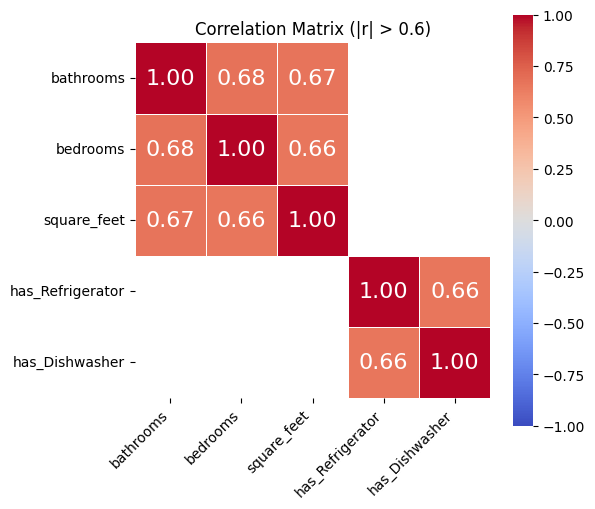

In [0]:
def plot_correlation_heatmap_WithFilter(correlation_matrix, column_names, threshold=0.6, title='Correlation Matrix'):
    # Create a mask for correlations below the threshold (in absolute value)
    mask = np.abs(correlation_matrix) <= threshold

    # Set diagonal to True to exclude self-correlations from consideration
    np.fill_diagonal(mask, True)

    # Find columns with at least one correlation above the threshold
    columns_to_keep = ~mask.all(axis=0)
    
    # If no columns meet the criteria, return early
    if not np.any(columns_to_keep):
        print("No correlations above the threshold were found.")
        return None

    # Filter the correlation matrix and column names
    filtered_matrix = correlation_matrix[columns_to_keep][:, columns_to_keep]
    filtered_column_names = [column_names[i] for i in range(len(column_names)) if columns_to_keep[i]]

    # Recreate the mask for the filtered matrix
    filtered_mask = np.abs(filtered_matrix) <= threshold
    np.fill_diagonal(filtered_mask, False)  # Show self-correlations in the plot

    # Calculate figure size based on number of columns
    n_cols = len(filtered_column_names)
    fig_size = (n_cols * 0.8 + 2, n_cols * 0.8 + 2)  # Adjust these multipliers as needed

    # Create a heatmap
    plt.figure(figsize=fig_size)
    sns.heatmap(filtered_matrix, 
                mask=filtered_mask,
                annot=True, 
                cmap='coolwarm', 
                vmin=-1, 
                vmax=1, 
                center=0,
                square=True, 
                linewidths=0.5, 
                fmt='.2f',
                xticklabels=filtered_column_names,
                yticklabels=filtered_column_names,
                annot_kws={"size": 16},  # Adjust text size as needed
                cbar_kws={"shrink": .8})  # Adjust colorbar size

    plt.title(f"{title} (|r| > {threshold})")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    
    return plt.tight_layout()

    
# Plot the heatmap (you can adjust the threshold here)
plot_correlation_heatmap_WithFilter(correlation_matrix, column_names, threshold=0.6)

In [0]:
 
# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Apply threshold
high_corr = corr_matrix.where(np.abs(corr_matrix) > .6)
display(high_corr)

bathrooms bedrooms price square_feet latitude longitude week_of_month has_Tennis has_Parking has_Alarm has_Golf has_TV has_Clubhouse has_Playground has_Refrigerator has_Cable_or_Satellite has_Unknown has_Gated has_Pool has_Wood_Floors has_Internet_Access has_View has_Elevator has_Hot_Tub has_Gym has_Storage has_Doorman has_Dishwasher has_Washer_Dryer has_Patio/Deck has_Garbage_Disposal has_Luxury has_AC has_Fireplace has_photo_no has_photo_yes pets_allowed_Yes 1.0 0.6785507254992077 NaN 0.6716269592610624 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 0.6785507254992077 1.0 NaN 0.6615681672898076 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 0.6716269592610624 0.6615681672898076 NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 0.6624100094559625 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN Na

### Calulating VIF for Entire Dataset

This is looking at the entire dataset to see if we have any very highly correlated columns. We see in the correlation matrix we have correlated columns but VIF will help us see a little more about how they may interact. Usually a VIF over 5 is too high and needs to be removed. 

In [0]:
type(numeric_df)

pyspark.pandas.frame.DataFrame

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.pandas as ps
from concurrent.futures import ThreadPoolExecutor, as_completed

# Ensure Spark session is created
spark = SparkSession.builder \
    .appName("VIF Calculation") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Assuming numeric_df is already defined as a pandas-on-Spark DataFrame
# Converting pandas-on-Spark DataFrame to a Spark DataFrame
vector_df = numeric_df.to_spark()

# List to store VIF results
vif_results = []

# Repartition the DataFrame based on its size
num_partitions = vector_df.rdd.getNumPartitions()
optimal_partitions = min(num_partitions, 200)
vector_df = vector_df.repartition(optimal_partitions)

# Function to calculate VIF for a single column
def calculate_vif(target_col, df):
    feature_cols = [col for col in vector_df.columns if col not in [target_col, 'unique_id']]    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    assembled_df = assembler.transform(df)
    train_data = assembled_df.select("features", target_col).cache()

    lr = LinearRegression(featuresCol="features", labelCol=target_col)
    lr_model = lr.fit(train_data)
    predictions = lr_model.transform(train_data)

    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target_col, metricName="r2")
    r_sq = evaluator.evaluate(predictions)
    vif = 1 / (1 - r_sq) if r_sq != 1 else float('inf')
    
    return (target_col, vif)

# Using ThreadPoolExecutor for concurrent execution
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust the number of workers as needed
    futures = {executor.submit(calculate_vif, col, vector_df): col for col in vector_df.columns}
    for future in as_completed(futures):
        col = futures[future]
        try:
            vif = future.result()
            vif_results.append(vif)
            # print(f"VIF for {col}: {vif[1]}")
        except Exception as e:
            print(f"Error calculating VIF for {col}: {e}")

# Print VIF results at the end
print("\nSummary of VIF for all columns:")

# Sort the vif_results list by VIF value in descending order
sorted_vif_results = sorted(vif_results, key=lambda x: x[1], reverse=True)

# Print the sorted results
for col_name, vif_value in sorted_vif_results:
    print(f"VIF for {col_name}: {vif_value}")

# for col_name, vif_value in vif_results:
#     print(f"VIF for {col_name}: {vif_value}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]


Summary of VIF for all columns:
VIF for bathrooms: 2.3624851836755787
VIF for square_feet: 2.339454459038783
VIF for bedrooms: 2.2664234690126075
VIF for has_Dishwasher: 2.1810783161091045
VIF for has_Refrigerator: 1.9591729080835734
VIF for has_Cable_or_Satellite: 1.6179120486024876
VIF for has_Gym: 1.6033882016075538
VIF for has_Unknown: 1.5758371809301963
VIF for has_Pool: 1.5703902700609371
VIF for has_photo_yes: 1.4836796573204838
VIF for has_AC: 1.4530923893716492
VIF for has_Washer_Dryer: 1.3539197127525244
VIF for has_Internet_Access: 1.3451229162250355
VIF for has_Clubhouse: 1.3295707004312385
VIF for price: 1.3242504302753955
VIF for has_Patio/Deck: 1.307685706804794
VIF for week_of_month: 1.2931466480414795
VIF for has_Parking: 1.2819032492905715
VIF for has_Garbage_Disposal: 1.2579875998447216
VIF for has_Fireplace: 1.2163191988166653
VIF for has_Playground: 1.1939382684898312
VIF for has_photo_no: 1.1842839427331735
VIF for has_Gated: 1.1659203164426049
VIF for has_Elevat

We have good VIF scores in our dataset so we will not remove any more columns. If there are moderately correlated columns we will take that into account in our analysis later on. 

### Summary Stats on dataset

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, min as spark_min, max as spark_max
import pyspark.pandas as ps
from concurrent.futures import ThreadPoolExecutor, as_completed

# Ensure Spark session is created
spark = SparkSession.builder \
    .appName("Summary Statistics Calculation") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Assuming numeric_df is already defined as a pandas-on-Spark DataFrame
# Converting pandas-on-Spark DataFrame to a Spark DataFrame
vector_df = numeric_df.to_spark()

# List to store summary statistics results
summary_results = []

# Repartition the DataFrame based on its size
num_partitions = vector_df.rdd.getNumPartitions()
optimal_partitions = __builtins__.min(num_partitions, 200) 
vector_df = vector_df.repartition(optimal_partitions)

# Function to calculate summary statistics for a single column
def calculate_summary_stats(column_name, df):
    summary_stats = df.select(
        mean(col(column_name)).alias("mean"),
        stddev(col(column_name)).alias("stddev"),
        spark_min(col(column_name)).alias("min"),
        spark_max(col(column_name)).alias("max")
    ).collect()[0]
    
    summary = {
        "column": column_name,
        "mean": summary_stats["mean"],
        "stddev": summary_stats["stddev"],
        "min": summary_stats["min"],
        "max": summary_stats["max"]
    }
    return summary

# Using ThreadPoolExecutor for concurrent execution
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust the number of workers as needed
    futures = {executor.submit(calculate_summary_stats, col_name, vector_df): col_name for col_name in vector_df.columns}
    for future in as_completed(futures):
        col_name = futures[future]
        try:
            summary = future.result()
            summary_results.append(summary)
            print(f"Summary statistics for {col_name}: {summary}")
        except Exception as e:
            print(f"Error calculating summary statistics for {col_name}: {e}")

# Print summary statistics results at the end
print("\nSummary Statistics for all columns:")
for result in summary_results:
    print(result)


Summary statistics for bedrooms: {'column': 'bedrooms', 'mean': 1.7257453500406965, 'stddev': 0.7504689092373312, 'min': 0, 'max': 9}
Summary statistics for week_of_month: {'column': 'week_of_month', 'mean': 3.1619924234050463, 'stddev': 0.8342202772785027, 'min': 1, 'max': 5}
Summary statistics for bathrooms: {'column': 'bathrooms', 'mean': 1.4446275510716762, 'stddev': 0.5477713573635926, 'min': 0.0, 'max': 9.0}
Summary statistics for has_Tennis: {'column': 'has_Tennis', 'mean': 0.08566375594119598, 'stddev': 0.27986829746043457, 'min': 0, 'max': 1}
Summary statistics for square_feet: {'column': 'square_feet', 'mean': 956.05147864184, 'stddev': 387.2192844112672, 'min': 101.0, 'max': 40000.0}
Summary statistics for price: {'column': 'price', 'mean': 1525.5443189605796, 'stddev': 902.0558524870771, 'min': 100.0, 'max': 52500.0}
Summary statistics for longitude: {'column': 'longitude', 'mean': -91.48728659826962, 'stddev': 15.737561003856273, 'min': -124.2265, 'max': -68.7788}
Summary 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Create a Spark session if you haven't already
spark_res_df = SparkSession.builder.getOrCreate()

def convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    else:
        return value  # Return as-is for other types (like strings)

# Preprocess the data
processed_summary_results = []
for item in summary_results:
    processed_item = {
        "column": item["column"],
        "mean": convert_to_float(item["mean"]),
        "stddev": convert_to_float(item["stddev"]),
        "min": convert_to_float(item["min"]),
        "max": convert_to_float(item["max"])
    }
    processed_summary_results.append(processed_item)

# Define the schema
schema = StructType([
    StructField("column", StringType(), True),
    StructField("mean", DoubleType(), True),
    StructField("stddev", DoubleType(), True),
    StructField("min", DoubleType(), True),
    StructField("max", DoubleType(), True)
])

# Create the Spark DataFrame
summary_result_df = spark_res_df.createDataFrame(processed_summary_results, schema)

# Show the DataFrame
summary_result_df.show()

+--------------------+--------------------+--------------------+---------+--------+
|              column|                mean|              stddev|      min|     max|
+--------------------+--------------------+--------------------+---------+--------+
|            bedrooms|  1.7257453500406965|  0.7504689092373312|      0.0|     9.0|
|       week_of_month|  3.1619924234050463|  0.8342202772785027|      1.0|     5.0|
|           bathrooms|  1.4446275510716762|  0.5477713573635926|      0.0|     9.0|
|          has_Tennis| 0.08566375594119598| 0.27986829746043457|      0.0|     1.0|
|         square_feet|     956.05147864184|   387.2192844112672|    101.0| 40000.0|
|               price|  1525.5443189605796|   902.0558524870771|    100.0| 52500.0|
|           longitude|  -91.48728659826962|  15.737561003856273|-124.2265|-68.7788|
|            latitude|  36.934092578152516|   4.560699440151283|  24.5645| 48.8467|
|         has_Parking| 0.44104022428328826|  0.4965140703692728|      0.0|  

In [0]:
summary_result_df.display()

column mean stddev min max bedrooms 1.7257453500406965 0.7504689092373312 0.0 9.0 week_of_month 3.1619924234050463 0.8342202772785027 1.0 5.0 bathrooms 1.4446275510716762 0.5477713573635926 0.0 9.0 has_Tennis 0.08566375594119598 0.27986829746043457 0.0 1.0 square_feet 956.05147864184 387.2192844112672 101.0 40000.0 price 1525.5443189605796 902.0558524870771 100.0 52500.0 longitude -91.48728659826962 15.737561003856273 -124.2265 -68.7788 latitude 36.934092578152516 4.560699440151283 24.5645 48.8467 has_Parking 0.44104022428328826 0.4965140703692728 0.0 1.0 has_Alarm 0.0036576665293366964 0.06036824185793644 0.0 1.0 has_TV 0.0452786961021735 0.20791577662422658 0.0 1.0 has_Golf 2.7131042937387584E-4 0.016469351705051993 0.0 1.0 has_Playground 0.11393028326818533 0.3177281672028879 0.0 1.0 has_Clubhouse 0.1923892400293417 0.3941791238298043 0.0 1.0 has_Cable_or_Satellite 0.12602871871137594 0.3318833945576695 0.0 1.0 has_Refrigerator 0.14987389089301326 0.3569495595114224 0.0 1.0 has_Gated 0.08717103610438418 0.28208694787488064 0.0 1.0 has_Pool 0.43822663464533695 0.49617187057161083 0.0 1.0 has_Unknown 0.15995257091753168 0.36656390464268557 0.0 1.0 has_View 0.02104163107810726 0.14352382321525303 0.0 1.0 has_Elevator 0.04360059085382397 0.20420577453855282 0.0 1.0 has_Wood_Floors 0.08925108272958389 0.2851072495882814 0.0 1.0 has_Internet_Access 0.11154878061034798 0.3148120805039674 0.0 1.0 has_Hot_Tub 0.04012379794406986 0.19625051794718615 0.0 1.0 has_Storage 0.21792256599374982 0.4128365703722296 0.0 1.0 has_Gym 0.3758955756302943 0.48435570528543753 0.0 1.0 has_Patio/Deck 0.2668790256941025 0.44233084608754325 0.0 1.0 has_Washer_Dryer 0.2620959233095853 0.43977675440699454 0.0 1.0 has_Luxury 0.002080046625199715 0.045560299487497735 0.0 1.0 has_Dishwasher 0.1667755257895636 0.37277720713600654 0.0 1.0 has_Garbage_Disposal 0.03893807088236181 0.19344837439825108 0.0 1.0 has_Doorman 0.002190580503833516 0.04675258094495654 0.0 1.0 has_photo_no 0.09274797270818051 0.2900803885426063 0.0 1.0 has_AC 0.15915873669825256 0.36582588483039546 0.0 1.0 has_photo_yes 0.5628184129344735 0.4960406429938882 0.0 1.0 has_Fireplace 0.15031602640754846 0.357382710879453 0.0 1.0 pets_allowed_Yes 0.9495161630676165 0.21894223170623736 0.0 1.0

In [0]:
numeric_df.describe()

bathrooms      bedrooms         price   square_feet      latitude     longitude  week_of_month    has_Tennis   has_Parking     has_Alarm      has_Golf        has_TV  has_Clubhouse  has_Playground  has_Refrigerator  has_Cable_or_Satellite   has_Unknown     has_Gated      has_Pool  has_Wood_Floors  has_Internet_Access      has_View  has_Elevator   has_Hot_Tub       has_Gym   has_Storage   has_Doorman  has_Dishwasher  has_Washer_Dryer  has_Patio/Deck  has_Garbage_Disposal   has_Luxury        has_AC  has_Fireplace  has_photo_no  has_photo_yes  pets_allowed_Yes
count  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000   99517.000000  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000   99517.000000    99517.000000      99517.000000            99517.000000  99517.000000  99517.000000  99517.000000     99517.000000         99517.000000  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000  99517.000000    99517.000000      99517.000000    99517.000000          99517.000000  99517.00000  99517.000000   99517.000000  99517.000000   99517.000000      99517.000000
mean       1.444628      1.725745   1525.544319    956.051479     36.934093    -91.487287       3.161992      0.085664      0.441040      0.003658      0.000271      0.045279       0.192389        0.113930          0.149874                0.126029      0.159953      0.087171      0.438227         0.089251             0.111549      0.021042      0.043601      0.040124      0.375896      0.217923      0.002191        0.166776          0.262096        0.266879              0.038938      0.00208      0.159159       0.150316      0.092748       0.562818          0.949516
std        0.547771      0.750469    902.055852    387.219284      4.560699     15.737561       0.834220      0.279868      0.496514      0.060368      0.016469      0.207916       0.394179        0.317728          0.356950                0.331883      0.366564      0.282087      0.496172         0.285107             0.314812      0.143524      0.204206      0.196251      0.484356      0.412837      0.046753        0.372777          0.439777        0.442331              0.193448      0.04556      0.365826       0.357383      0.290080       0.496041          0.218942
min        0.000000      0.000000    100.000000    101.000000     24.564500   -124.226500       1.000000      0.000000      0.000000      0.000000      0.000000      0.000000       0.000000        0.000000          0.000000                0.000000      0.000000      0.000000      0.000000         0.000000             0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000        0.000000          0.000000        0.000000              0.000000      0.00000      0.000000       0.000000      0.000000       0.000000          0.000000
25%        1.000000      1.000000   1014.000000    730.000000     33.746500   -104.791900       3.000000      0.000000      0.000000      0.000000      0.000000      0.000000       0.000000        0.000000          0.000000                0.000000      0.000000      0.000000      0.000000         0.000000             0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000        0.000000          0.000000        0.000000              0.000000      0.00000      0.000000       0.000000      0.000000       0.000000          1.000000
50%        1.000000      2.000000   1350.000000    900.000000     37.213900    -84.538200       3.000000      0.000000      0.000000      0.000000      0.000000      0.000000       0.000000        0.000000          0.000000                0.000000      0.000000      0.000000      0.000000         0.000000             0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000        0.000000          0.000000        0.000000              0.000000      0.00000      0.000000       0.000000      0.000000       1.000000          1.000000

### Linear Regression across Dataset

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
import pyspark.pandas as ps

# Ensure Spark session is created
spark = SparkSession.builder \
    .appName("Linear Regression with Manual Feature Assembly") \
    .config("spark.sql.shuffle.partitions", "200")  \
    .getOrCreate()

# Converting pandas-on-Spark DataFrame to a Spark DataFrame
vector_df = numeric_df.to_spark()

# Define the target column
target_col = "price"

# Manually create one-hot encoded columns for week_of_month
for i in range(1, 5):  # Assuming weeks are 1-4
    vector_df = vector_df.withColumn(f"week_{i}", when(col("week_of_month") == i, 1).otherwise(0))

# Standardize 'square feet'
assembler = VectorAssembler(inputCols=["square_feet"], outputCol="square_feet_vec")
scaler = StandardScaler(inputCol="square_feet_vec", outputCol="scaled_square_feet")
vector_df = assembler.transform(vector_df)
scaler_model = scaler.fit(vector_df)
vector_df = scaler_model.transform(vector_df)

# Extract the scaled square feet from the vector
get_first = udf(lambda v: float(v[0]), returnType=DoubleType())
vector_df = vector_df.withColumn("scaled_square_feet", get_first("scaled_square_feet"))

# Define the order of features
feature_cols = ['latitude', 'longitude', 'has_Tennis', 'has_Parking', 'has_Alarm', 'has_Golf', 'has_TV', 'has_Clubhouse','has_Playground', 'has_Refrigerator', 'has_Cable_or_Satellite', 'has_Unknown','has_Gated', 'has_Pool', 'has_Wood_Floors', 'has_Internet_Access', 'has_View', 'has_Elevator', 'has_Hot_Tub', 'has_Gym', 'has_Storage', 'has_Doorman','has_Dishwasher', 'has_Washer_Dryer', 'has_Patio/Deck', 'has_Garbage_Disposal','has_Luxury', 'has_AC', 'has_Fireplace', 'has_photo_no', 'has_photo_yes','pets_allowed_Yes', 'bathrooms', 'bedrooms', 'scaled_square_feet', 'week_1', 'week_2', 'week_3', 'week_4']

# Create a UDF to assemble features into a vector
@udf(returnType=VectorUDT())
def assemble_features(*cols):
    return Vectors.dense([float(c) for c in cols])

# Apply the UDF to create the feature vector
vector_df = vector_df.withColumn("features", assemble_features(*feature_cols))

# Select the features and target columns for training
train_data = vector_df.select("features", target_col)

# Examine the structure of train_data
print("\nStructure of train_data:")
train_data.show(5, truncate=False)

# Print the number of features in train_data
num_features = len(feature_cols)
print(f"\nNumber of features in train_data: {num_features}")

# Set up and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=target_col)
lr_model = lr.fit(train_data)

# Extract coefficients and intercept
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f"\nNumber of coefficients: {len(coefficients)}")

# Compare the number of features and coefficients
if num_features == len(coefficients):
    print("The number of features matches the number of coefficients.")
else:
    print(f"Mismatch: {num_features} features vs {len(coefficients)} coefficients.")

# Get the summary of the model
training_summary = lr_model.summary

# Extract summary statistics
r_squared = training_summary.r2
adjusted_r_squared = training_summary.r2adj
rmse = training_summary.rootMeanSquaredError
mae = training_summary.meanAbsoluteError
explained_variance = training_summary.explainedVariance

# Create a pandas-on-Spark DataFrame for coefficients including the intercept
coeff_psdf = ps.DataFrame({
    "Feature": feature_cols + ["Intercept"],
    "Coefficient": list(coefficients) + [intercept]
})

# Add a new column for the absolute value of coefficients and sort by it
coeff_psdf['abs_coefficient'] = coeff_psdf['Coefficient'].abs()
coeff_psdf = coeff_psdf.sort_values(by='abs_coefficient', ascending=False).drop(columns=['abs_coefficient'])

# Create a pandas-on-Spark DataFrame for summary statistics
summary_stats = {
    "R-squared": [r_squared],
    "Adjusted R-squared": [adjusted_r_squared],
    "RMSE": [rmse],
    "MAE": [mae],
    "Explained Variance": [explained_variance],
    "Total Iterations": [training_summary.totalIterations]
}

summary_stats_psdf = ps.DataFrame(summary_stats)

# Display the DataFrames
print("\nCoefficients:")
print(coeff_psdf)
print("\nModel Summary Statistics:")
print(summary_stats_psdf)
# Uncache the DataFrame
train_data.unpersist()


Structure of train_data:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                                                                             |price |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[39.0342,-94.5429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0,6.456290016136541,0.0,0.0,0.0,1.0] |800.0 |
|[37.5423,-77.4347,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,2.259701505647789,0.0,0.0,0.0,1.0] |1000.0|
|[33.9222,-84.0725,

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]


Number of coefficients: 39
The number of features matches the number of coefficients.

Coefficients:
                   Feature  Coefficient
21             has_Doorman  1148.716768
39               Intercept  -714.878015
17            has_Elevator   499.418298
34      scaled_square_feet   332.941781
32               bathrooms   263.245148
14         has_Wood_Floors   237.347215
8           has_Playground  -202.845298
4                has_Alarm   201.098182
16                has_View   198.102579
25    has_Garbage_Disposal  -156.083536
38                  week_4  -152.516798
7            has_Clubhouse  -136.133296
33                bedrooms  -119.110003
5                 has_Golf   115.999245
36                  week_2   -98.548117
6                   has_TV    97.574141
19                 has_Gym    90.706536
23        has_Washer_Dryer   -88.462153
28           has_Fireplace   -73.894957
29            has_photo_no    65.849407
10  has_Cable_or_Satellite   -59.640026
24          has_Pa

DataFrame[features: vector, price: double]

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf, monotonically_increasing_id
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.linalg import VectorUDT
import pyspark.pandas as ps

# Ensure Spark session is created
spark = SparkSession.builder \
    .appName("Feature Preparation for Analysis") \
    .config("spark.sql.shuffle.partitions", "200")  \
    .getOrCreate()

# Converting pandas-on-Spark DataFrame to a Spark DataFrame
vector_df = numeric_df.to_spark()

# Define the target column
target_col = "price"

# Add a unique ID column
vector_df = vector_df.withColumn("unique_id", monotonically_increasing_id())

# Manually create one-hot encoded columns for week_of_month
for i in range(1, 5):  # Assuming weeks are 1-4
    vector_df = vector_df.withColumn(f"week_{i}", when(col("week_of_month") == i, 1).otherwise(0))

# Standardize 'square feet'
assembler = VectorAssembler(inputCols=["square_feet"], outputCol="square_feet_vec")
scaler = StandardScaler(inputCol="square_feet_vec", outputCol="scaled_square_feet")
vector_df = assembler.transform(vector_df)
scaler_model = scaler.fit(vector_df)
vector_df = scaler_model.transform(vector_df)

# Create a UDF to extract the first (and only) element from the vector
@udf(returnType=DoubleType())
def extract_from_vector(v):
    return float(v[0])

# Extract the scaled square feet from the vector
vector_df = vector_df.withColumn("scaled_square_feet", extract_from_vector(col("scaled_square_feet")))

# Define the columns we want to keep
columns_to_keep = [
    'unique_id',
    'latitude', 'longitude', 
    'has_Tennis', 'has_Parking', 'has_Alarm', 'has_Golf', 'has_TV', 'has_Clubhouse',
    'has_Playground', 'has_Refrigerator', 'has_Cable_or_Satellite', 'has_Unknown',
    'has_Gated', 'has_Pool', 'has_Wood_Floors', 'has_Internet_Access', 'has_View',
    'has_Elevator', 'has_Hot_Tub', 'has_Gym', 'has_Storage', 'has_Doorman',
    'has_Dishwasher', 'has_Washer_Dryer', 'has_Patio/Deck', 'has_Garbage_Disposal',
    'has_Luxury', 'has_AC', 'has_Fireplace', 'has_photo_no', 'has_photo_yes',
    'pets_allowed_Yes', 
    'bathrooms', 'bedrooms', 'scaled_square_feet',
    'week_1', 'week_2', 'week_3', 'week_4',
    target_col
]

# Create the final DataFrame with only the columns we need
final_df = vector_df.select(columns_to_keep)

# Convert to pandas-on-Spark DataFrame for easier viewing
final_psdf = final_df.pandas_api()

# Display info about the final DataFrame
print(final_psdf.info())

# Display the first few rows of the final DataFrame
print("\nFirst few rows of the final DataFrame:")
final_psdf.head()

# Save the final DataFrame for further analysis
# Uncomment the following line if you want to save it as a CSV file
# final_psdf.to_csv('prepared_rental_data.csv', index=False)


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 99517 entries, 0 to 95562
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unique_id               99517 non-null  int64  
 1   latitude                99517 non-null  float64
 2   longitude               99517 non-null  float64
 3   has_Tennis              99517 non-null  int32  
 4   has_Parking             99517 non-null  int32  
 5   has_Alarm               99517 non-null  int32  
 6   has_Golf                99517 non-null  int32  
 7   has_TV                  99517 non-null  int32  
 8   has_Clubhouse           99517 non-null  int32  
 9   has_Playground          99517 non-null  int32  
 10  has_Refrigerator        99517 non-null  int32  
 11  has_Cable_or_Satellite  99517 non-null  int32  
 12  has_Unknown             99517 non-null  int32  
 13  has_Gated               99517 non-null  int32  
 14  has_Pool                99517 non-n

unique_id  latitude  longitude  has_Tennis  has_Parking  has_Alarm  has_Golf  has_TV  has_Clubhouse  has_Playground  has_Refrigerator  has_Cable_or_Satellite  has_Unknown  has_Gated  has_Pool  has_Wood_Floors  has_Internet_Access  has_View  has_Elevator  has_Hot_Tub  has_Gym  has_Storage  has_Doorman  has_Dishwasher  has_Washer_Dryer  has_Patio/Deck  has_Garbage_Disposal  has_Luxury  has_AC  has_Fireplace  has_photo_no  has_photo_yes  pets_allowed_Yes  bathrooms  bedrooms  scaled_square_feet  week_1  week_2  week_3  week_4   price
0          0   39.0342   -94.5429           0            0          1         0       0              0               0                 1                       0            0          0         0                0                    0         0             0            0        0            0            0               0                 0               0                     0           0       0              1             0              1                 1        1.0         3            6.456290       0       0       0       1   800.0
1          1   37.5423   -77.4347           0            0          0         0       1              0               0                 1                       1            0          0         0                1                    1         0             0            0        0            0            0               1                 0               1                     1           0       1              0             0              1                 1        2.0         2            2.259702       0       0       0       1  1000.0
2          2   33.9222   -84.0725           1            0          0         0       0              0               0                 1                       0            0          1         1                0                    0         0             0            0        1            0            0               1                 1               1                     0           0       1              1             0              0                 1        1.0         1            2.014362       0       0       1       0  1017.0
3          3   36.1599   -78.8975           0            1          0         0       0              0               0                 0                       0            0          0         1                0                    0         0             0            0        0            0            0               0                 1               0                     0           0       0              0             0              1                 1        2.0         2            2.879505       0       0       1       0  1023.0
4          4   28.0395   -82.3952           0            0          0         0       0              0               0                 0                       0            0          0         1                0                    0         0             0            0        0            0            0               0                 0               0                     0           0       0              0             0              1                 1        1.5         2            3.357271       0       0       0       1  1025.0

In [0]:
summary_stats_psdf.display()
coeff_psdf.display()

R-squared Adjusted R-squared RMSE MAE Explained Variance Total Iterations 0.2497908409776205 0.24949672115895016 781.3082812382936 477.6321843139007 203253.95413435763 0

Feature Coefficient has_Doorman 1148.7167676165839 Intercept -714.878014571396 has_Elevator 499.41829834028454 scaled_square_feet 332.94178089917335 bathrooms 263.2451481138218 has_Wood_Floors 237.34721530559665 has_Playground -202.84529822548024 has_Alarm 201.09818175498555 has_View 198.1025786087673 has_Garbage_Disposal -156.08353562283395 week_4 -152.51679771144896 has_Clubhouse -136.13329618871902 bedrooms -119.11000269091117 has_Golf 115.99924525105642 week_2 -98.54811710308732 has_TV 97.57414134223637 has_Gym 90.706535685193 has_Washer_Dryer -88.46215297666268 has_Fireplace -73.89495668117976 has_photo_no 65.84940700298462 has_Cable_or_Satellite -59.640025604448525 has_Patio/Deck 58.14295008391875 week_1 56.48716931487229 has_Storage -44.021378199388494 has_Luxury 42.00737779701831 has_Hot_Tub 39.87582885358747 has_Refrigerator -38.1367880892332 has_Parking 26.81381941385856 week_3 19.927477921930628 has_Internet_Access 18.75199634433781 has_AC -16.719452095245575 has_Tennis -15.076323314998662 has_Gated 14.511716773885327 latitude 14.481362792222722 has_photo_yes 10.668123624570054 has_Pool -8.475591367472179 longitude -8.217181919323505 has_Unknown 4.4140434411031215 pets_allowed_Yes 1.4771320751831025 has_Dishwasher -0.19908565558793928

### Scaling Data, Silhouette, Kmeans and Clustering 

We had some optimization issues which we solved with some spark caching, threadpooling and parallelization. 

In [0]:
import pyspark.pandas as ps
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
import time
from concurrent.futures import ThreadPoolExecutor

# Assuming you have a Spark session already created
spark = SparkSession.builder.getOrCreate()

# Assuming numeric_df is your pandas-on-Spark DataFrame
# Step 1: Create a unique_id column
# numeric_df = numeric_df.reset_index(drop=True)
# numeric_df['unique_id'] = numeric_df.index
#
# Step 2: Select the necessary columns
df = final_psdf[['unique_id', 'latitude', 'longitude']]

# Convert pandas-on-Spark DataFrame to Spark DataFrame for MLlib compatibility
df_spark = df.to_spark()

# Assemble the features
vector_assembler = VectorAssembler(inputCols=['latitude', 'longitude'], outputCol='features')
df_spark = vector_assembler.transform(df_spark)

# Cache the DataFrame to optimize performance
df_spark.cache()

# Step 3: Define a function to perform k-means clustering and compute silhouette score and WCSS
def compute_metrics(k, df_spark):
    evaluator = ClusteringEvaluator()
    start_time = time.time()
    kmeans = KMeans(k=k, seed=42)
    model = kmeans.fit(df_spark)
    transformed = model.transform(df_spark)
    silhouette = evaluator.evaluate(transformed)
    wcss = model.summary.trainingCost
    end_time = time.time()
    elapsed_time = end_time - start_time
    return k, silhouette, wcss, elapsed_time

# Create a list of k values
k_values = list(range(2, 81))

# Step 4: Use ThreadPoolExecutor to parallelize metric computation
metrics = []

def parallel_compute_metrics(k):
    return compute_metrics(k, df_spark)

with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust max_workers based on your cluster
    results = list(executor.map(parallel_compute_metrics, k_values))

metrics = results

# Print metrics and computation times
for k, silhouette, wcss, time_taken in metrics:
    print(f"k: {k}, Silhouette Score: {silhouette}, WCSS: {wcss}, Time Taken: {time_taken} seconds")

# Step 5: Determine the optimal k based on silhouette scores
optimal_k = max(metrics, key=lambda x: x[1])[0]
print(f"Optimal k based on Silhouette Score: {optimal_k}")

# Perform k-means clustering with the optimal k
kmeans = KMeans(k=optimal_k, seed=42)
model = kmeans.fit(df_spark)
df_spark = model.transform(df_spark)

# Convert back to pandas-on-Spark DataFrame if needed
result_df = ps.DataFrame(df_spark.select('unique_id', 'latitude', 'longitude', 'prediction'))

# Show the resultsss
result_df.head()

# Clean up
df_spark.unpersist()

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

k: 2, Silhouette Score: 0.763449034248761, WCSS: 7819512.118361829, Time Taken: 12.302191257476807 seconds
k: 3, Silhouette Score: 0.7066676965898263, WCSS: 4130639.958093457, Time Taken: 56.06333518028259 seconds
k: 4, Silhouette Score: 0.626529195061003, WCSS: 3066695.262633371, Time Taken: 12.9237060546875 seconds
k: 5, Silhouette Score: 0.6570225770709357, WCSS: 2184460.5820053252, Time Taken: 12.365989923477173 seconds
k: 6, Silhouette Score: 0.674843772590051, WCSS: 1734666.9166672565, Time Taken: 12.941851377487183 seconds
k: 7, Silhouette Score: 0.6453930030584214, WCSS: 1369393.9327533566, Time Taken: 13.146583557128906 seconds
k: 8, Silhouette Score: 0.6668562607779775, WCSS: 1375699.5277522383, Time Taken: 12.790895223617554 seconds
k: 9, Silhouette Score: 0.7479653824112578, WCSS: 796316.6247356371, Time Taken: 14.169133424758911 seconds
k: 10, Silhouette Score: 0.718012839465669, WCSS: 797762.747828376, Time Taken: 6.459659814834595 seconds
k: 11, Silhouette Score: 0.70812

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

DataFrame[unique_id: bigint, latitude: double, longitude: double, features: vector, prediction: int]

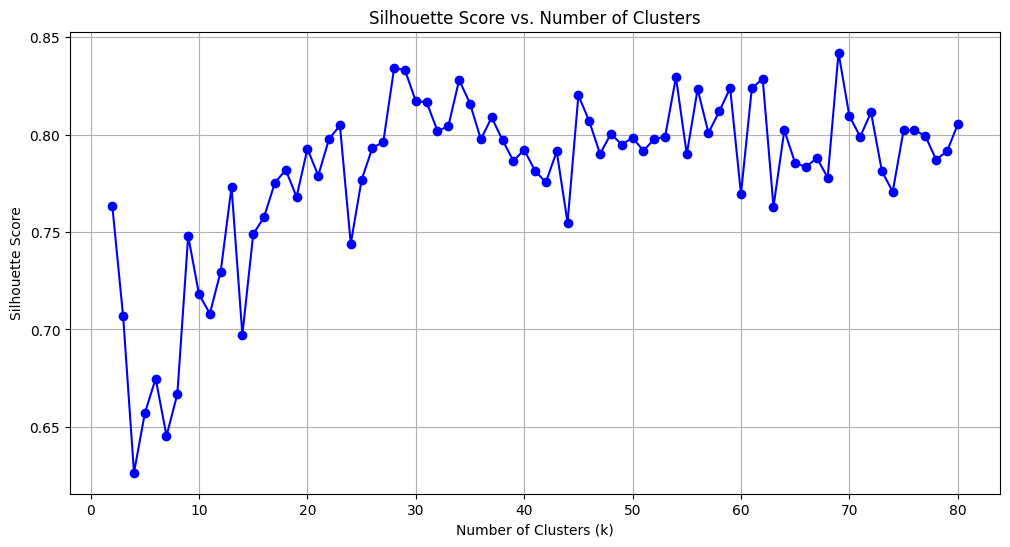

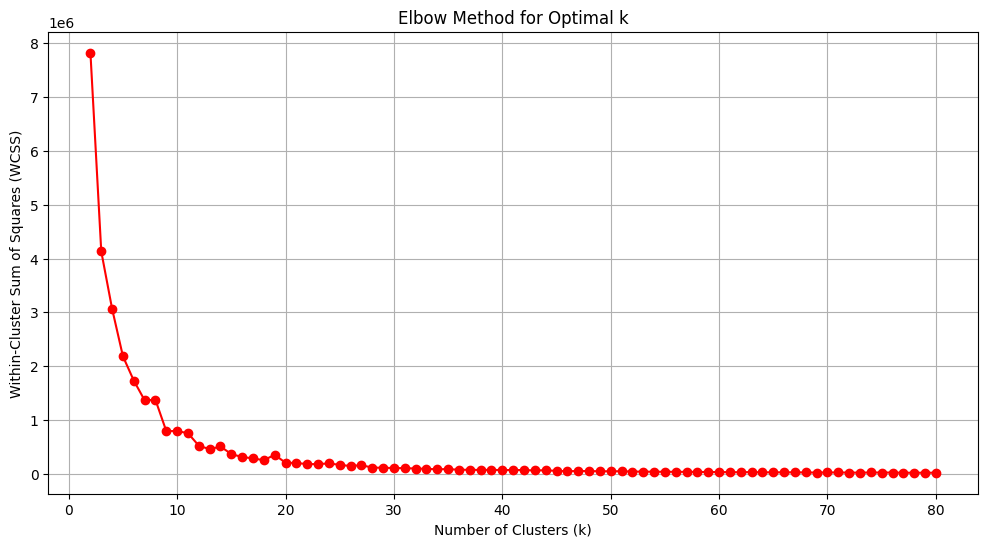

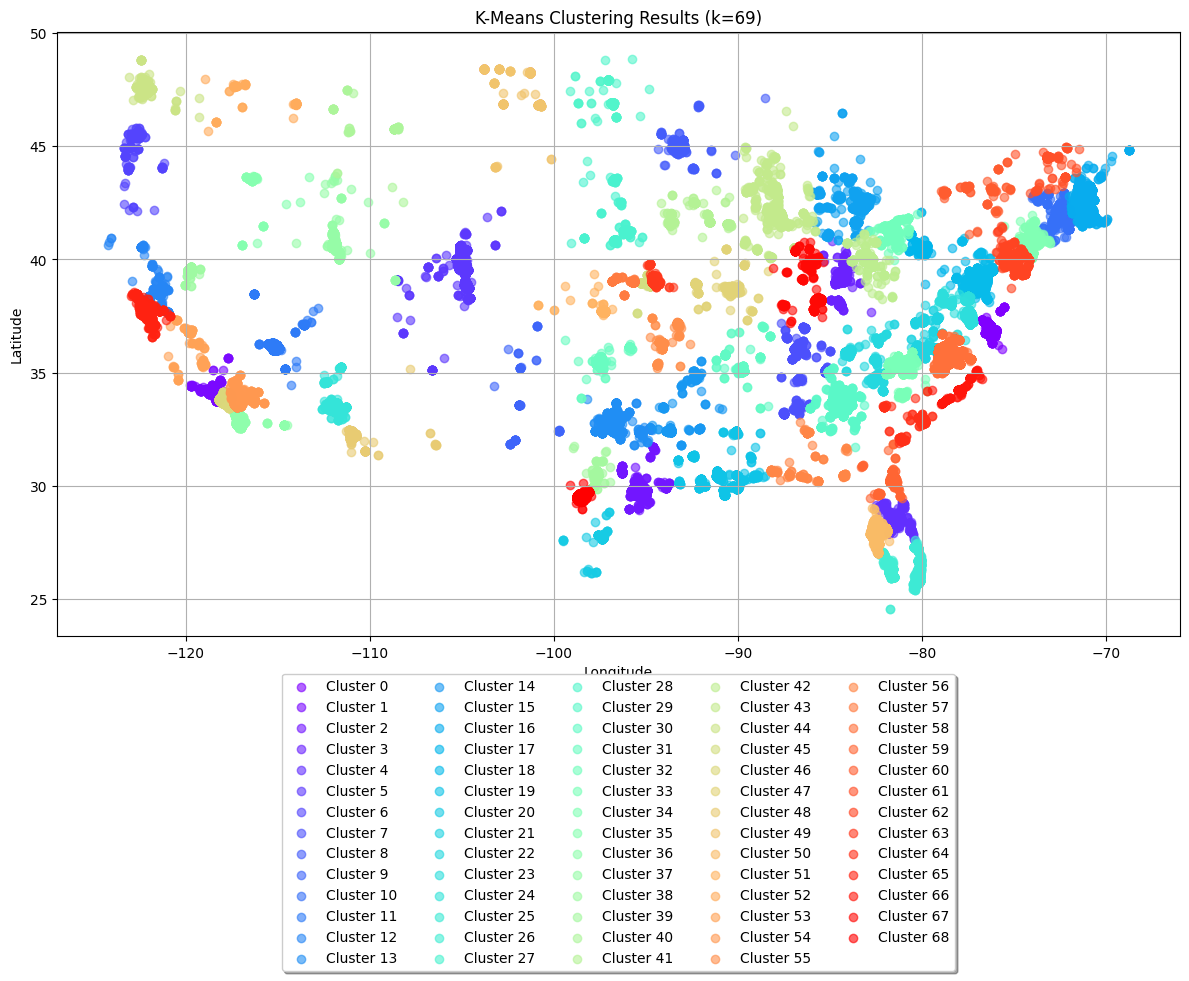

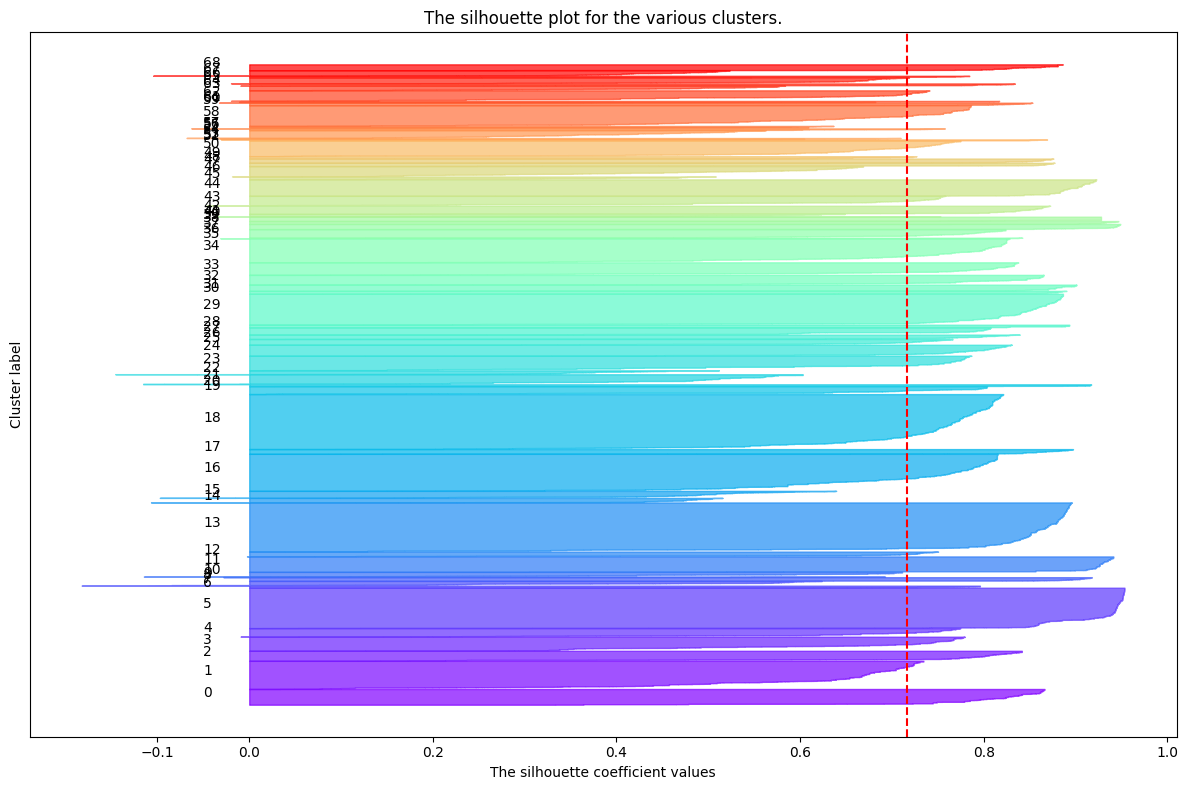

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples

# Extract data for plotting
k_values, silhouette_values, wcss_values, _ = zip(*metrics)

# Plot 1: Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(k_values, silhouette_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

# Plot 2: Elbow Plot (WCSS)
plt.figure(figsize=(12, 6))
plt.plot(k_values, wcss_values, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Plot 3: Clustered Data Points
plt.figure(figsize=(12, 10))  # Increased figure height to accommodate legend below

# Convert PySpark DataFrame to numpy arrays
predictions = result_df['prediction'].to_numpy()
longitudes = result_df['longitude'].to_numpy()
latitudes = result_df['latitude'].to_numpy()

# Get unique cluster labels and sort them
unique_labels = sorted(np.unique(predictions))

# Create a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# Plot each cluster
for label, color in zip(unique_labels, colors):
    mask = predictions == label
    plt.scatter(longitudes[mask], latitudes[mask], 
                c=[color], label=f'Cluster {label}', alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'K-Means Clustering Results (k={optimal_k})')

# Sort the legend labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0].split()[-1])))

# Place legend below the chart
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)  # Adjust ncol as needed

plt.grid(True)
plt.tight_layout()  # Adjust the plot to ensure all elements are visible
plt.show()

# Plot 4: Silhouette Plot
plt.figure(figsize=(12, 8))

# Compute silhouette scores for each sample
silhouette_samples_values = silhouette_samples(np.column_stack((longitudes, latitudes)), predictions)

y_lower = 10
for i in range(optimal_k):
    # Aggregate the silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = silhouette_samples_values[predictions == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = colors[i]
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=np.mean(silhouette_samples_values), color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()

# Optional: Save the plots
# plt.savefig('silhouette_scores.png')
# plt.savefig('elbow_plot.png')
# plt.savefig('clustering_results.png', bbox_inches='tight')  # Ensure legend is included when saving
# plt.savefig('silhouette_plot.png', bbox_inches='tight')

In [0]:
import pyspark.pandas as ps

# Convert result_df to a pandas-on-Spark DataFrame
result_psdf = result_df

# Ensure result_psdf has only the necessary columns
result_psdf = result_psdf[['unique_id', 'prediction']]

# Merge the cluster assignments back to the original dataframe
# nonscaled_clustered_df = numeric_df.merge(
#     result_psdf,
#     on='unique_id',
#     how='left'
# )

# Merge the cluster assignments back to the original dataframe
clustered_df = final_psdf.merge(
    result_psdf,
    on='unique_id',
    how='left'
)

# Show the first few rows of the result
display(clustered_df.head())

# Get some basic statistics about the clusters
cluster_stats = clustered_df.groupby('prediction').agg({
    'unique_id': 'count',
    'latitude': ['mean', 'min', 'max'],
    'longitude': ['mean', 'min', 'max']
}).reset_index()

print("\nCluster Statistics:")
print(cluster_stats)

# Optional: Save the clustered dataframe
# clustered_df.to_csv('clustered_data.csv', index=False)

unique_id latitude longitude has_Tennis has_Parking has_Alarm has_Golf has_TV has_Clubhouse has_Playground has_Refrigerator has_Cable_or_Satellite has_Unknown has_Gated has_Pool has_Wood_Floors has_Internet_Access has_View has_Elevator has_Hot_Tub has_Gym has_Storage has_Doorman has_Dishwasher has_Washer_Dryer has_Patio/Deck has_Garbage_Disposal has_Luxury has_AC has_Fireplace has_photo_no has_photo_yes pets_allowed_Yes bathrooms bedrooms scaled_square_feet week_1 week_2 week_3 week_4 price prediction 0 39.05 -84.3439 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1.0 1 1.9962848729894185 0 0 1 0 1000.0 3 1 35.9165 -78.9177 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1.0 1 2.174478477434787 0 1 0 0 1008.0 58 2 41.4779 -87.3058 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1.0 1 1.8542464926344144 0 1 0 0 1019.0 43 3 32.91 -97.5572 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1.0 1 1.8723241046795969 0 0 1 0 1025.0 13 4 32.7767 -97.0816 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0.0 1 1.9652946809119631 0 0 1 0 1040.0 13


Cluster Statistics:
   prediction unique_id   latitude                     longitude                    
                  count       mean      min      max        mean       min       max
0          31       964  35.458441  33.8994  36.4297  -97.438064  -99.3992  -95.7854
1          65       928  37.676690  36.5877  38.5392 -122.150870 -122.9650 -120.8502
2          53       123  36.288060  34.6530  37.3395 -119.723941 -120.9770 -118.9327
3          34      3739  40.752542  40.0711  41.9398  -74.146435  -75.5692  -73.0548
4          28       410  47.151638  44.3600  48.8467  -96.939593  -99.1233  -94.8577
5          27      1120  41.298523  40.6246  43.7274  -96.257838  -99.0865  -95.2202
6          26       679  26.400779  24.5645  27.0783  -81.821737  -82.3809  -81.5339
7          44      2562  47.587022  46.2858  48.7871 -122.186509 -123.0586 -119.2833
8          12       749  38.689381  37.6656  40.9288 -121.466670 -124.2265 -120.9456
9          22       602  35.415762  34.1847 

In [0]:
clustered_df.columns

Index(['unique_id', 'latitude', 'longitude', 'has_Tennis', 'has_Parking',
       'has_Alarm', 'has_Golf', 'has_TV', 'has_Clubhouse', 'has_Playground',
       'has_Refrigerator', 'has_Cable_or_Satellite', 'has_Unknown',
       'has_Gated', 'has_Pool', 'has_Wood_Floors', 'has_Internet_Access',
       'has_View', 'has_Elevator', 'has_Hot_Tub', 'has_Gym', 'has_Storage',
       'has_Doorman', 'has_Dishwasher', 'has_Washer_Dryer', 'has_Patio/Deck',
       'has_Garbage_Disposal', 'has_Luxury', 'has_AC', 'has_Fireplace',
       'has_photo_no', 'has_photo_yes', 'pets_allowed_Yes', 'bathrooms',
       'bedrooms', 'scaled_square_feet', 'week_1', 'week_2', 'week_3',
       'week_4', 'price', 'prediction'],
      dtype='object')

### VIF scores and Linear Regressions by Cluster

We created several functions that calculate the VIF score for each cluster. This isn't trivial because it requires checking for constant columns, removing highly correlated columns with VIF scores above 5 and looping this process until all the columns have a VIF score under 5. 

We also calculated a Linear Regression for each cluster according to the VIF feature selection process. We save it all into a dataframe for viewing. 

In [0]:
# renaming the prediction column for readability 
clustered_df = clustered_df.rename(columns={'prediction': 'clusters'})
clustered_df.columns

Index(['unique_id', 'latitude', 'longitude', 'has_Tennis', 'has_Parking',
       'has_Alarm', 'has_Golf', 'has_TV', 'has_Clubhouse', 'has_Playground',
       'has_Refrigerator', 'has_Cable_or_Satellite', 'has_Unknown',
       'has_Gated', 'has_Pool', 'has_Wood_Floors', 'has_Internet_Access',
       'has_View', 'has_Elevator', 'has_Hot_Tub', 'has_Gym', 'has_Storage',
       'has_Doorman', 'has_Dishwasher', 'has_Washer_Dryer', 'has_Patio/Deck',
       'has_Garbage_Disposal', 'has_Luxury', 'has_AC', 'has_Fireplace',
       'has_photo_no', 'has_photo_yes', 'pets_allowed_Yes', 'bathrooms',
       'bedrooms', 'scaled_square_feet', 'week_1', 'week_2', 'week_3',
       'week_4', 'price', 'clusters'],
      dtype='object')

We had an issue where the pandas dataframe to output the results would not work when using pyspark dataframes. There was a conflict with worker nodes and driver. 

In [0]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Spark session
spark = SparkSession.builder \
    .appName("VIF Calculation and Price Prediction") \
    .getOrCreate()

# Assuming clustered_df is a pandas-on-Spark DataFrame
cluster_col = 'clusters'
unique_id_col = 'unique_id'
price_col = 'price'
numeric_columns = [col for col in clustered_df.columns if col not in [unique_id_col, cluster_col, price_col]]

# Convert to Spark DataFrame for efficient processing
spark_df = clustered_df.to_spark()

def remove_constant_columns(df):
    return df.loc[:, df.nunique() != 1]

def calculate_vif(pdf, feature_cols):
    vif_data = []
    for col_name in feature_cols:
        y = pdf[col_name]
        X = pdf[[x for x in feature_cols if x != col_name]]
        lr = LinearRegression().fit(X, y)
        r2 = lr.score(X, y)
        vif = 1 / (1 - r2)
        vif_data.append((col_name, vif))
    return pd.DataFrame(vif_data, columns=['feature', 'VIF'])

def iterative_vif(pdf, feature_cols, threshold=5):
    while True:
        vif_df = calculate_vif(pdf, feature_cols)
        max_vif = vif_df['VIF'].max()
        if max_vif < threshold:
            break
        feature_to_remove = vif_df.loc[vif_df['VIF'].idxmax(), 'feature']
        feature_cols.remove(feature_to_remove)
        if len(feature_cols) < 2:
            break
    return vif_df, feature_cols

def predict_price(pdf, feature_cols):
    X = pdf[feature_cols]
    y = pdf[price_col]
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)

    n = len(y)
    p = len(feature_cols)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

    return pd.DataFrame({'feature': feature_cols, 'coefficient': model.coef_}), model.intercept_, mse, r2, adjusted_r2

result_schema = StructType([
    StructField("feature", StringType(), True),
    StructField("VIF", DoubleType(), True),
    StructField("coefficient", DoubleType(), True),
    StructField("cluster", IntegerType(), True),
    StructField("intercept", DoubleType(), True),
    StructField("mse", DoubleType(), True),
    StructField("r2", DoubleType(), True),
    StructField("adjusted_r2", DoubleType(), True),
    StructField("row_count", IntegerType(), True)


])

def process_group(pdf):
    cluster_value = pdf[cluster_col].iloc[0]
    row_count = len(pdf)
    non_constant_df = remove_constant_columns(pdf[numeric_columns])
    feature_cols = non_constant_df.columns.tolist()
    
    if len(feature_cols) < 2:
        return pd.DataFrame(columns=['feature', 'VIF', 'coefficient', 'cluster', 'intercept', 'mse', 'r2', 'adjusted_r2', 'row_count'])
    
    vif_df, final_features = iterative_vif(non_constant_df, feature_cols)
    
    coef_df, intercept, mse, r2, adjusted_r2 = predict_price(pdf, final_features)
    
    result_df = vif_df[vif_df['feature'].isin(final_features)].merge(coef_df, on='feature', how='left')
    result_df['cluster'] = cluster_value
    result_df['intercept'] = intercept
    result_df['mse'] = mse
    result_df['r2'] = r2
    result_df['adjusted_r2'] = adjusted_r2
    result_df['row_count'] = row_count

    return result_df

# Apply the function to each group using groupBy and applyInPandas
results = spark_df.groupBy(cluster_col).applyInPandas(process_group, schema=result_schema)

# Convert to pandas for easier manipulation and display
results_pd = results.toPandas()

# Display results
print("\nResults for each cluster:")
for cluster in results_pd['cluster'].unique():
    cluster_results = results_pd[results_pd['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print("Features, VIF, and Coefficients:")
    print(cluster_results[['feature', 'VIF', 'coefficient']])
    print(f"Intercept: {cluster_results['intercept'].iloc[0]}")
    print(f"Mean Squared Error: {cluster_results['mse'].iloc[0]}")
    print(f"R-squared: {cluster_results['r2'].iloc[0]}")
    print(f"Adjusted R-squared: {cluster_results['adjusted_r2'].iloc[0]}")
    print(f"Row count: {cluster_results['row_count'].iloc[0]}")

# Optional: Save to CSV
# results_pd.to_csv('vif_and_regression_results_by_cluster.csv', index=False)


Results for each cluster:

Cluster 1:
Features, VIF, and Coefficients:
                   feature       VIF  coefficient
0                 latitude  1.136220  -247.743354
1                longitude  1.136633 -1149.969492
2               has_Tennis  1.164859    26.878715
3              has_Parking  1.372739   -17.928283
4                has_Alarm  1.025505  -439.268167
5                   has_TV  1.143097   280.431279
6            has_Clubhouse  1.202413   -56.860778
7           has_Playground  1.146448  -128.586345
8         has_Refrigerator  1.665827    49.902413
9   has_Cable_or_Satellite  1.804974  -111.926752
10             has_Unknown  1.609796    26.719641
11               has_Gated  1.513861  -264.302005
12                has_Pool  1.555737   248.563655
13         has_Wood_Floors  1.169279  -142.578390
14     has_Internet_Access  1.568422   242.817799
15                has_View  1.069060   222.489605
16            has_Elevator  1.564472   351.235785
17             has_Hot_Tub  

In [0]:
# Assuming results_pd is your pandas DataFrame with the results

# Get VIF results
vif_results = results_pd[['cluster', 'feature', 'VIF']]

# Pivot the results to get columns as features and rows as clusters
vif_pivot = vif_results.pivot(index='cluster', columns='feature', values='VIF')

# Fill NaN values with 'Constant' to indicate constant columns in that cluster
vif_pivot = vif_pivot.fillna('Constant')

# Sort columns alphabetically
vif_pivot = vif_pivot.reindex(sorted(vif_pivot.columns), axis=1)

# Print the results
print("\nVIF values for each feature by cluster:")
display(vif_pivot)

# Optional: Save to CSV
# vif_pivot.to_csv('vif_results_by_cluster.csv')

print("\nNote: 'Constant' indicates that the feature was constant within that cluster.")


VIF values for each feature by cluster:


/databricks/spark/python/pyspark/sql/pandas/conversion.py:413: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Could not convert 'Constant' with type str: tried to convert to double
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


bathrooms bedrooms has_AC has_Alarm has_Cable_or_Satellite has_Clubhouse has_Dishwasher has_Doorman has_Elevator has_Fireplace has_Garbage_Disposal has_Gated has_Golf has_Gym has_Hot_Tub has_Internet_Access has_Luxury has_Parking has_Patio/Deck has_Playground has_Pool has_Refrigerator has_Storage has_TV has_Tennis has_Unknown has_View has_Washer_Dryer has_Wood_Floors has_photo_no has_photo_yes latitude longitude pets_allowed_Yes scaled_square_feet week_1 week_2 week_3 week_4 2.4313366469111446 2.38908059149533 1.5783112544252038 1.3675680513779922 2.1409330091799403 1.5758662718925405 2.5286587342995803 Constant 1.3785178307740282 1.4234438270366876 1.551855981367239 1.1870914690336536 Constant 1.9280968340448836 1.1343034913231496 1.909597179075757 1.0082173126405871 1.447800084764559 1.5760612968687036 1.697917242608278 1.9799157328126682 1.7245756061901039 1.4353857117171984 1.719822345666638 1.3873075297868265 1.5199018865539182 1.1873804466211637 1.6053475285319163 1.182579244330641 1.1529739540435022 1.2461857667536582 1.5861296658582458 1.5518041332339716 1.0513697434664815 2.794695940274564 1.0315284989305222 1.0252404003413278 Constant 1.2193279673108346 2.901135167990877 2.3235739799030473 1.6574184415142563 1.0255047419095686 1.8049736709365445 1.2024125233993486 1.9410705162188633 1.026988450122588 1.5644717102636794 1.2353406871134645 1.1305105788496186 1.5138614412617817 Constant 1.5433060776614251 1.2699000860421927 1.5684224985176207 1.0095177893266927 1.3727390389488563 1.2884426181212996 1.1464479156797636 1.5557370505725343 1.6658266404657909 1.106799905653073 1.143096902539268 1.1648594772869822 1.6097962877668683 1.0690597996655222 1.1522902893697797 1.1692794752680078 1.4456488391716165 1.7250251838755504 1.136219710849327 1.1366327004006547 1.0559162807426818 2.4936592174552494 1.0625038472890709 1.2958253472865175 Constant 1.34570662714226 3.1613433939527935 3.7904670607744992 1.6050503304766364 1.0251071785840935 1.6943723188740996 1.2232508830641333 4.192245190310863 Constant 1.1154444241989858 1.3121328656157012 1.8743508838102967 1.130961306609217 1.0298200001969777 1.612920437464191 1.0615435665073059 1.489116959440945 Constant 1.311581104809747 1.5309656593711065 1.1531644119694064 1.4441732840424828 3.3885745899086133 1.2755862107126716 1.1222856786663244 1.1735714936396884 1.4330262931901374 1.0195880362760248 1.5340990147220055 1.0748168944657526 1.1058116899324468 Constant 1.4040350081368147 1.3060686858955133 1.139499431172358 3.267460709409809 Constant 1.3187360024154868 1.3931682820258968 1.973192352823795 2.2064670074330346 2.3394317824896196 1.5098481967979938 1.1250026104243382 2.021440879037626 1.6835005244593617 2.453484150258959 Constant 1.0820954498555768 1.5299368790437915 1.2868141623942329 1.2778777989376222 Constant 2.19467970535803 1.1187773160577144 1.6700654287546686 1.0239998812377127 1.6407112246282558 1.3961065888340254 1.2861143402212831 2.16663476880811 2.422975636295253 1.3750108771808087 1.337370887555502 1.461539335214416 1.9959623223181138 1.0252542472322228 1.4673935165291967 1.1749309976168287 1.3537827211652333 1.6057256141705822 2.3067935914958695 1.427659554111605 1.1340517482916548 2.888789473958262 1.010955232377544 1.04083212885838 Constant 2.569481524622883 2.9380721385921604 3.5715526094634757 2.119034908935995 1.1538404706281173 1.9646062358641778 1.7642785539902188 2.870404418273747 1.1210185572818498 1.0782337793637746 1.5355955705061706 1.429630711205407 1.6241701061981253 Constant 2.1630435679657753 1.229423443858726 1.6133966022345114 1.0262458352764074 1.4819698195775546 1.40732342998891 1.7931668370571 1.7750554823064435 2.700127869677813 1.4259779126348209 1.4783818680832879 1.56195969400404 1.6380384542659112 1.0714954740144507 1.7601624562648852 1.5471473515505534 1.4794022952656023 2.0928735180807103 1.870003291736483 2.349385486420554 1.2075641065386402 3.677211708245454 Constant 1.1212324598369825 2.8353374572983476 3.6509224225245474 2.7605809


Note: 'Constant' indicates that the feature was constant within that cluster.


In [0]:
import pandas as pd

# Assuming results_pd is the DataFrame containing the results

# Create a list to store each cluster's data
combined_results_list = []

# Iterate over each cluster
for cluster in results_pd['cluster'].unique():
    # Filter the results for the current cluster
    cluster_results = results_pd[results_pd['cluster'] == cluster]
    
    # Create a dictionary to hold the results for the current cluster
    cluster_data = {
        'cluster': cluster,
        'intercept': cluster_results['intercept'].iloc[0],
        'mse': cluster_results['mse'].iloc[0],
        'r2': cluster_results['r2'].iloc[0],
        'adjusted_r2': cluster_results['adjusted_r2'].iloc[0],
        'row_count': cluster_results['row_count'].iloc[0]

    }
    
    # Add the coefficients to the dictionary
    for _, row in cluster_results.iterrows():
        cluster_data[row['feature']] = row['coefficient']
    
    # Append the dictionary to the list
    combined_results_list.append(cluster_data)

# Convert the list of dictionaries to a DataFrame
combined_results = pd.DataFrame(combined_results_list)

# Set the cluster column as the index
combined_results.set_index('cluster', inplace=True)

# Display the combined results
print("Combined Results Table:")
display(combined_results)

# Optional: Save to CSV
combined_results.to_csv('combined_results_by_cluster.csv')


Combined Results Table:


intercept mse r2 adjusted_r2 row_count latitude longitude has_Tennis has_Parking has_Alarm has_TV has_Clubhouse has_Playground has_Refrigerator has_Cable_or_Satellite has_Unknown has_Gated has_Pool has_Wood_Floors has_Internet_Access has_View has_Elevator has_Hot_Tub has_Gym has_Storage has_Doorman has_Dishwasher has_Washer_Dryer has_Patio/Deck has_Garbage_Disposal has_Luxury has_AC has_Fireplace has_photo_no has_photo_yes pets_allowed_Yes bathrooms bedrooms scaled_square_feet week_1 week_2 week_4 week_3 has_Golf -127855.00168877741 1849043.8334700346 0.6105100713030106 0.6072040085909691 4397 -247.74335445340458 -1149.9694917920797 26.878714865526863 -17.92828290721685 -439.26816714293295 280.4312786674494 -56.86077813483782 -128.58634532080825 49.902412869435736 -111.92675217115328 26.719641482832643 -264.3020048784857 248.56365462463296 -142.5783903555907 242.81779873197542 222.48960483783654 351.23578532186315 -69.63204796105116 21.028659498150024 -34.58972838270154 1778.7385313485897 -168.95148308722057 17.489561350725868 -7.775955952677445 -296.48806302084824 636.488718149034 -168.87766162797365 -17.110676662069096 63.012089056794366 -45.78148282637764 298.00692137432816 776.5531355747135 -271.61101464536426 986.0876347900331 -131.93238834623406 -708.9194586045452 -371.16525290589647 null null -5068.981980932094 62606.5545276049 0.6074576652344965 0.5876100190946676 749 -290.0522563768183 -139.52568909639223 43.47608767285304 31.05213526835461 27.61375087726749 -32.49669320194862 73.15336168802831 44.57785590707506 -33.32375163278415 -73.6759933814315 120.8872980942828 -25.730952879459952 50.645735092697244 117.61486299506952 -25.432871135755338 -14.5146117997188 711.5047542886936 109.25977904430509 51.145623429501136 -5.886668322037511 null 24.212583167414003 107.75997286996176 -78.01440322260069 -36.551375794745546 -208.30970783903626 -89.5548045841247 -11.550000438109421 38.18091465655659 11.031244157526158 58.47329916289276 212.03186825249801 -79.7907113054889 247.7866121926943 137.85856611485303 -320.3354494301346 null 100.14794238989678 null 1193.6600269323744 37715.09578971941 0.5788756843542795 0.5536230798887514 602 -64.68563672126847 -14.950512997453888 -15.723407905761821 85.6693747941552 null -71.40195643961448 9.36080427114875 -77.718157837365 -3.84696940130162 21.139151913644284 43.98189257909877 61.84166915477438 79.19600345877856 19.81270680069636 2.358233832171756 -15.219874830637846 272.56413772300334 186.11861236464355 1.1100496173768164 7.9992683806744695 null -61.868463517560244 -13.89162873228789 -48.76816202129029 -123.36714807573117 null -12.359942644868646 39.07586445182439 120.65031391022946 129.98192093126423 115.8760905894438 42.441056145559564 24.07094716121875 174.92082829063523 173.58777632412978 null 220.20409862130663 9.65413841964755 null -263846.43893598486 2251678.5538327172 0.5093369571263023 0.48101475340348354 679 -2590.291689070392 -4059.7187709964696 686.0977252917683 -140.93479266716324 -1454.0941111393681 430.6747646730339 -60.057967666549615 -656.544585121958 72.4357647115488 -635.9224235746592 56.74497031906794 -333.804514022356 509.00748501059917 -636.1202349223488 29.185229925518478 287.92614129280474 74.49364464081006 -592.500675794562 138.43417294147037 -558.7738356926156 null -26.907470524325184 -146.6312077483235 119.52644402234395 -802.9846734662495 750.7052912002545 35.57799596632853 5795.457881044483 -346.8581323066133 -338.92041480217114 34.91883921678576 -53.975796766535396 -40.96458078486021 825.6423132940197 652.7509762513384 -1439.4374615524994 null -371.2891727200766 1559.3943863547863 4044.5581003572042 26833.93966146942 0.6173742372465155 0.6046553753267321 1120 -18.337100565156618 31.541352899957218 -13.994645791805858 57.106376167142805 null -47.22830001823652 33.66659307406798 -65.83067599553048 21.402016169170025 46.34523570716006 68.92569917792453 188.26596826686722 -9.992078627668675 -35.9066368717289 3.3860012781204154 -143.918867471183 78.6476987761964

In [0]:
# Optional: Save to CSV
combined_results.to_csv('combined_results_by_cluster.csv')

In [0]:
combined_results.describe().to_csv('combined_described.csv')
combined_results.describe()

intercept           mse  ...      week_3     has_Golf
count      69.000000  6.900000e+01  ...   46.000000    17.000000
mean    -5635.192481  1.933318e+05  ...   13.209264   260.479285
std     51299.270208  4.184157e+05  ...  274.773274   572.135298
min   -263846.438936  1.270063e+04  ... -484.607531 -1003.836785
25%    -14855.705798  4.266518e+04  ... -142.657305    30.179795
50%      -172.678827  6.909435e+04  ...    0.127003   214.278831
75%      8025.502776  1.391550e+05  ...  124.145645   376.510910
max    167884.620031  2.251679e+06  ...  778.523095  1559.394386

[8 rows x 44 columns]

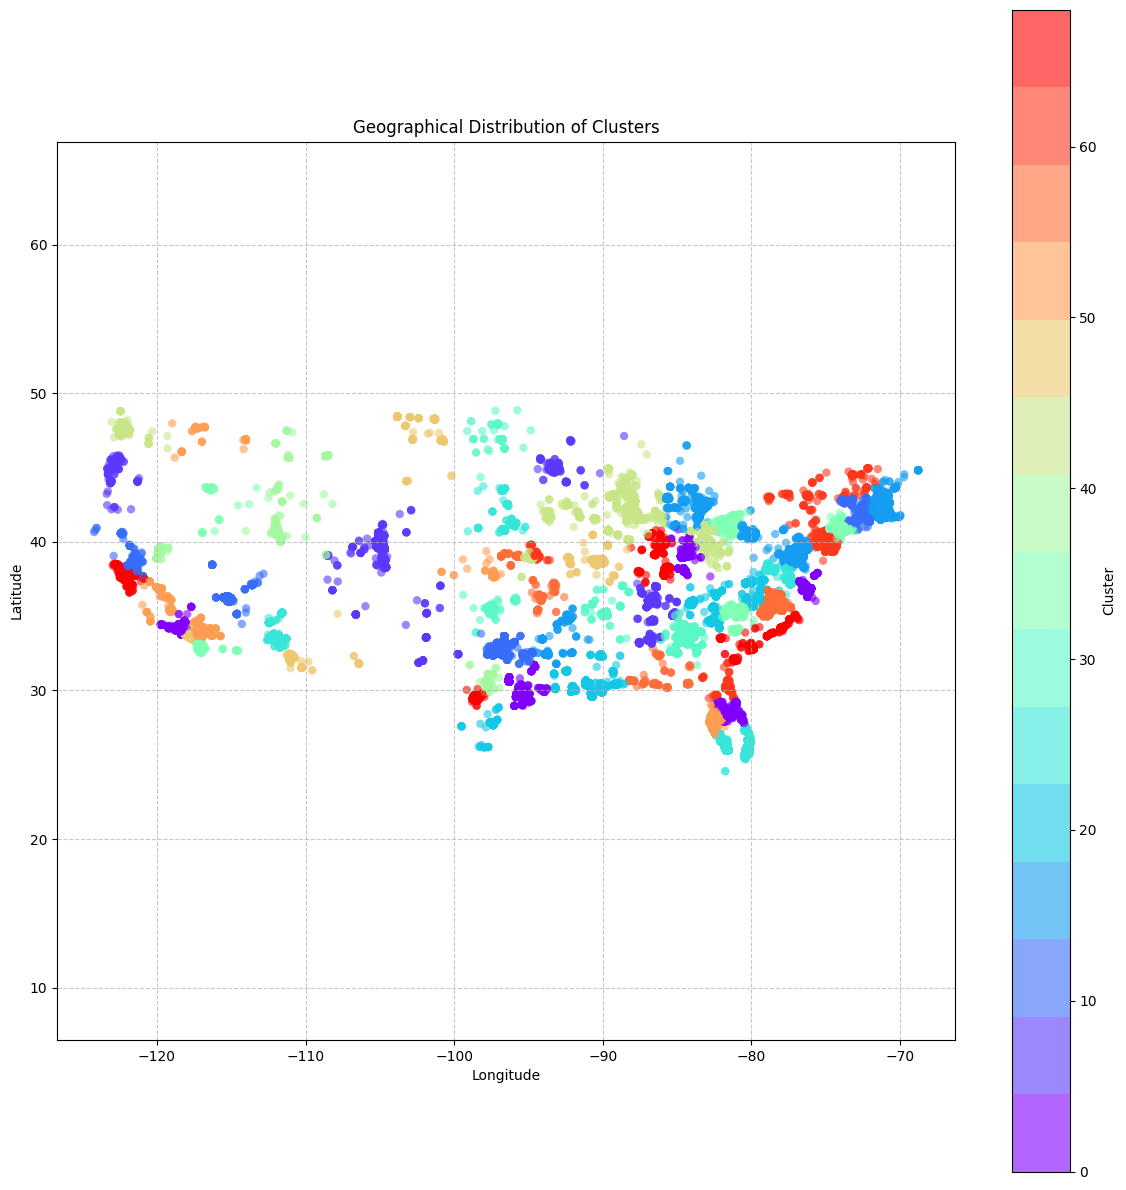

Clusters range from 0 to 68
Cluster map has been displayed.


In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plot_clusters_on_map(df):
    df = df.to_spark()
    # Collect the data
    data = df.select('latitude', 'longitude', 'clusters').collect()
    
    # Separate the data into lists
    latitudes = [row['latitude'] for row in data]
    longitudes = [row['longitude'] for row in data]
    clusters = [row['clusters'] for row in data]

    # Get unique clusters and their range
    unique_clusters = sorted(set(clusters))
    min_cluster = min(unique_clusters)
    max_cluster = max(unique_clusters)

    # Create a custom colormap
    n_bins = 15  # Number of color bins
    colors = plt.cm.rainbow(np.linspace(0, 1, n_bins))
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

    # Create the scatter plot with a square aspect ratio
    plt.figure(figsize=(12, 12))  # Equal width and height
    
    scatter = plt.scatter(longitudes, latitudes, c=clusters, cmap=cmap, 
                          alpha=0.6, edgecolors='none')

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster')

    # Set labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Geographical Distribution of Clusters')

    # Set aspect ratio to 'equal' for a true square plot
    plt.gca().set_aspect('equal', adjustable='box')

    # Add grid lines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust plot limits to focus on the data
    x_range = max(longitudes) - min(longitudes)+ 5
    y_range = max(latitudes) - min(latitudes) + 5
    max_range = max(x_range, y_range)
    x_center = (max(longitudes) + min(longitudes)) / 2
    y_center = (max(latitudes) + min(latitudes)) / 2
    
    plt.xlim(x_center - max_range/2, x_center + max_range/2)
    plt.ylim(y_center - max_range/2, y_center + max_range/2)

    # Improve the layout
    plt.tight_layout()

    # Display the plot
    display(plt.gcf())
    plt.close()

    print(f"Clusters range from {min_cluster} to {max_cluster}")

# Assuming 'clustered_df' is your DataFrame with clusters, latitude, and longitude
plot_clusters_on_map(clustered_df)

print("Cluster map has been displayed.")

In [0]:
import pyspark.pandas as ps
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import colorsys
import numpy as np

def generate_colors(n):
    HSV_tuples = [(x * 1.0 / n, 0.5, 0.5) for x in range(n)]
    return list(map(lambda x: f'rgb{tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x))}', HSV_tuples))

def calculate_zoom(x1, x2, y1, y2):
    max_bound = max(abs(x1-x2), abs(y1-y2)) * 111
    return 11.5 - np.log(max_bound)

def plot_clusters_on_map(df):
    # Ensure df is a pandas-on-Spark DataFrame
    if not isinstance(df, ps.DataFrame):
        df = ps.DataFrame(df)
    
    # Convert to numpy arrays
    latitudes = df['latitude'].to_numpy()
    longitudes = df['longitude'].to_numpy()
    predictions = df['clusters'].to_numpy()
    
    # Get unique clusters
    unique_clusters = np.unique(predictions)
    
    # Create a colorscale with enough unique colors
    colorscale = generate_colors(len(unique_clusters))
    
    # Calculate bounds and zoom
    x1, x2 = np.min(longitudes), np.max(longitudes)
    y1, y2 = np.min(latitudes), np.max(latitudes)
    center_lon = (x1 + x2) / 2
    center_lat = (y1 + y2) / 2
    zoom = calculate_zoom(x1, x2, y1, y2)
    
    # Create subplot with two columns
    fig = make_subplots(rows=1, cols=2, column_widths=[0.8, 0.2], 
                        specs=[[{"type": "scattermapbox"}, {"type": "scatter"}]])
    
    # Calculate the maximum prediction value for size reference
    max_prediction = np.max(predictions)
    
    # Add scatter mapbox trace for each cluster
    for cluster, color in zip(unique_clusters, colorscale):
        cluster_mask = predictions == cluster
        cluster_lats = latitudes[cluster_mask]
        cluster_lons = longitudes[cluster_mask]
        
        if len(cluster_lats) > 0:
            fig.add_trace(
                go.Scattermapbox(
                    lat=cluster_lats,
                    lon=cluster_lons,
                    mode='markers',
                    marker=dict(
                        size=8,
                        color=color,
                        opacity=0.7,
                        sizemin=3,
                        sizemode='area',
                        sizeref=2.*max_prediction/10.**2
                    ),
                    text=predictions[cluster_mask],
                    hoverinfo='text',
                    name=f'Cluster {cluster}',
                    showlegend=False
                ),
                row=1, col=1
            )
    
    # Add traces for the custom legend
    for cluster, color in zip(unique_clusters, colorscale):
        fig.add_trace(
            go.Scatter(
                x=[None], y=[None],
                mode='markers',
                marker=dict(size=10, color=color),
                showlegend=True,
                name=f'Cluster {cluster}'
            ),
            row=1, col=2
        )
    
    # Update layout with calculated center and zoom, and zoom constraints
    fig.update_layout(
        mapbox=dict(
            style="open-street-map",
            center=dict(lat=center_lat, lon=center_lon),
            zoom=zoom        
        ),
        showlegend=True,
        legend=dict(
            itemsizing='constant',
            title='Clusters',
            bgcolor='rgba(255,255,255,0.6)',
            bordercolor='rgba(0,0,0,0.5)',
            borderwidth=1
        ),
        width=1200,
        height=800,
        hovermode='closest'
    )
    
    # Update the second subplot (legend) layout
    fig.update_xaxes(visible=False, row=1, col=2)
    fig.update_yaxes(visible=False, row=1, col=2)
    
    # Display the plot
    fig.show()

    # Print cluster range
    min_cluster = np.min(predictions)
    max_cluster = np.max(predictions)
    print(f"Clusters range from {min_cluster} to {max_cluster}")

# Assuming 'clustered_df' is your pandas-on-Spark DataFrame with clusters, latitude, and longitude
plot_clusters_on_map(clustered_df)

print("Interactive cluster map has been displayed.")

Clusters range from 0 to 68
Interactive cluster map has been displayed.
